In [1]:
# Get the population from a CCEA that learned with dynamic influence
# Just 1 uav and 1 rover
# Generate 50 new joint trajectories with random poi locations
# Now I have many joint trajectories, and the policies those joint trajectories came from

# Give me a histogram of the performance of each run
# Give me a histogram of the influence from uav to rover in each run (hard-coded influence)
# Compute influence based on counterfactual what-ifs of what the rover would have done without the uav if the uav were removed
# (and I can compute this perfectly because I have the exact policy of the rover and I can reconstruct the environment with the uav removed)
# Now give me a histogram of that

In [2]:
from pathlib import Path
from typing import List, Optional, Any
import os
import cppyy
import pandas as pd
import pickle
from copy import deepcopy
import numpy as np
import yaml
import matplotlib.pyplot as plt
from influence.plotting import plot_joint_trajectory, generate_joint_trajectory_plot, PlotArgs
from influence.ccea_lib import CooperativeCoevolutionaryAlgorithm, TeamInfo, NeuralNetwork, EvalInfo, JointTrajectory
from influence.custom_env import createAgent, createHiddenPOI
from influence.librovers import rovers, thyme
from matplotlib import font_manager

In [ ]:
# Let's load in a population
base_dir = Path(
    os.path.expanduser(
        '~/influence-shaping/results/01_05_2025/yabby/31_more_circ   les/1x1/D-Indirect-Timestep-no-preservation'
    )
)
population_dir = base_dir / 'trial_0' / 'checkpoint_1000.pkl'
with open(population_dir, "rb") as file:
    population = pickle.load(file)

In [4]:
# Let's get a team (if I remember correctly, the leftmost index of each subpopluation should have the elite for that subpop)
elite_team = [subpop[0] for subpop in population]

# Set up to run the team in the environment
t_infos = [
    TeamInfo(
        policies=elite_team,
        seed=i
    )
    for i in range(50)
]
template_policies = [
    NeuralNetwork(
        num_inputs=12,
        num_hidden=[15],
        num_outputs=2,
        hidden_activation_func='tanh',
        output_activation_func='tanh'
    )
]*2
config_dir = base_dir / 'config.yaml'
with open(str(config_dir), 'r') as file:
    config = yaml.safe_load(file)

# Let's run that team 50 times in the environment
outs = []
for team_info in t_infos:
    out = CooperativeCoevolutionaryAlgorithm.evaluateTeamStatic(
        team = team_info,
        template_policies = template_policies,
        config=config,
        num_rovers=1,
        num_uavs=1,
        num_steps=50,
        compute_team_fitness=True
    )
    outs.append(out)

In [5]:
def build_mini_df(eval_info: EvalInfo):
    """ This dataframe will just have positions and actions
    """
    # Format the positions
    rover_xs = []
    rover_ys = []

    uav_xs = []
    uav_ys = []

    # poi doesn't move, just keeping consistency
    poi_xs = []
    poi_ys = []

    for state in eval_info.joint_trajectory.states[:50]:
        rover_xs.append(state[0][0])
        rover_ys.append(state[0][1])
        uav_xs.append(state[1][0])
        uav_ys.append(state[1][1])
        poi_xs.append(state[2][0])
        poi_ys.append(state[2][1])

    rover_dxs = []
    rover_dys = []

    uav_dxs = []
    uav_dys = []

    for action in eval_info.joint_trajectory.actions:
        rover_dxs.append(action[0][0])
        rover_dys.append(action[0][1])
        uav_dxs.append(action[1][0])
        uav_dys.append(action[1][1])

    data = {
        'rover_0_x': rover_xs,
        'rover_0_y': rover_ys,
        'uav_0_x' : uav_xs,
        'uav_0_y': uav_ys,
        'hidden_poi_0_x': poi_xs,
        'hidden_poi_0_y': poi_ys,
        'rover_0_dx': rover_dxs,
        'rover_0_dy': rover_dys,
        'uav_0_dx': uav_dxs,
        'uav_0_dy': uav_dys
    }

    return pd.DataFrame(data)

def build_traj_df(eval_info: EvalInfo):
    """ This dataframe includes positions, observations, and actions
    """
    # Get the max len of data based on the actions
    max_len = len(eval_info.joint_trajectory.actions)

    # Format the positions
    rover_xs = []
    rover_ys = []

    uav_xs = []
    uav_ys = []

    # poi doesn't move, just keeping consistency
    poi_xs = []
    poi_ys = []

    for state in eval_info.joint_trajectory.states[:max_len]:
        rover_xs.append(state[0][0])
        rover_ys.append(state[0][1])
        uav_xs.append(state[1][0])
        uav_ys.append(state[1][1])
        poi_xs.append(state[2][0])
        poi_ys.append(state[2][1])

    # Format the observations
    rover_obs = [
        [] for _ in range(12)
    ]
    uav_obs = [
        [] for _ in range(12)
    ]

    # Save observations
    for observations in eval_info.joint_trajectory.observations[:max_len]:
        # observations is all the observations at one timestep
        # save rover observation at this step
        rover_observation_arr = observations[0]
        for sensor_reading, rover_sensor_history in zip(rover_observation_arr, rover_obs):
            rover_sensor_history.append(sensor_reading)
        # save uav observation at this step
        uav_observation_arr = observations[1]
        for sensor_reading, uav_sensor_history in zip(uav_observation_arr, uav_obs):
            uav_sensor_history.append(sensor_reading)

    rover_dxs = []
    rover_dys = []

    uav_dxs = []
    uav_dys = []

    for action in eval_info.joint_trajectory.actions:
        rover_dxs.append(action[0][0])
        rover_dys.append(action[0][1])
        uav_dxs.append(action[1][0])
        uav_dys.append(action[1][1])

    data = {
        'rover_0_x': rover_xs,
        'rover_0_y': rover_ys,
        'uav_0_x' : uav_xs,
        'uav_0_y': uav_ys,
        'hidden_poi_0_x': poi_xs,
        'hidden_poi_0_y': poi_ys,
        'rover_0_dx': rover_dxs,
        'rover_0_dy': rover_dys,
        'uav_0_dx': uav_dxs,
        'uav_0_dy': uav_dys
    }

    # Add in observations seperately because there are so many
    for i, rover_sensor_history in enumerate(rover_obs):
        data['rover_0_obs_'+str(i)] = rover_sensor_history
    for i, uav_sensor_history in enumerate(uav_obs):
        data['uav_0_obs_'+str(i)] = uav_sensor_history

    return pd.DataFrame(data)

In [6]:
# Build out the joint trajectories as mini dataframes
traj_dfs = [build_traj_df(out) for out in outs]

# Save those dataframes (and config, and population)
# to have a complete package to work with
save_dir = Path( os.path.expanduser('~') ) / 'influence-shaping' / 'results' / '02_19_2025' / '01_influence'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# this awkward naming scheme is necessary for plotting tools
trajs_dir = save_dir / 'original' / 'traj' / 'traj'
if not os.path.exists(trajs_dir):
    os.makedirs(trajs_dir)

# save the trajectories
df_dirs = [trajs_dir / ('traj_'+str(i)+'.csv') for i in range(len(traj_dfs))]
for df_dir, df in zip(df_dirs, traj_dfs):
    df.to_csv(df_dir, index=False)

# Save config
config_dir = save_dir / 'original' / 'config.yaml'
with open(config_dir, "w") as file:
    yaml.dump(config, file, default_flow_style=False)

# save the population here too
pkl_dir = save_dir / 'population.pkl'
with open(pkl_dir, "wb") as file:
    pickle.dump(population, file)

In [7]:
# Let's save a plot of each joint trajectory
save_fig_dir = Path(os.path.expanduser('~')) / 'influence-shaping' / 'outfigs' / '02_19_2025' / '01_influence'
base_out_dir = save_fig_dir / 'original'
for df_dir in df_dirs:
    plot_joint_trajectory(
        joint_traj_dir=df_dir,
        individual_colors=False,
        no_shading=False,
        plot_args=PlotArgs(
            output=base_out_dir / (df_dir.name+'.png')
        )
    )

In [8]:
# Now I want to start being able to do re-sim in order to compute step-by-step counterfactuals

# Different options
# 1. Hold uav still and see what the rover does with an input policy, however many steps forward
# 2. Remove the uav entirely and see what the rover does with an input policy, however many steps forward
# 3. Hold rover still and see what uav does
# 4. Remove rover entirely and see what the uav does

def resim_env(
        num_steps: int,
        rover_config: dict,
        uav_config: dict,
        poi_config: dict,
        poi_position: List[float],
        uav_position: Optional[List[float]] = None,
        rover_position: Optional[List[float]] = None,
        uav_action: Optional[List[float]] = None,
        rover_action: Optional[List[float]] = None,
        uav_policy_function: Optional[Any] = None,
        rover_policy_function: Optional[Any] = None,
    ):
    """
    None means we are removing this position or action
    """
    # Create the environment as specified
    # For these initial experiments, a lot of this will be hardcoded,
    # and I can make this more flexible later

    # Set up variables that aggregate info from both rover and uav
    agent_positions = []
    if rover_position is not None:
        agent_positions.append(rover_position)
    if uav_position is not None:
        agent_positions.append(uav_position)

    agent_types = []
    if rover_position is not None:
        agent_types.append('rover')
    if uav_position is not None:
        agent_types.append('uav')

    agent_observable_subtypes = []
    if rover_position is not None:
        agent_observable_subtypes.append([])
    if uav_position is not None:
        agent_observable_subtypes.append([])

    observation_radii = []
    if rover_position is not None:
        observation_radii.append(rover_config['observation_radius'])
    if uav_position is not None:
        observation_radii.append(uav_config['observation_radius'])

    default_values = []
    if rover_position is not None:
        default_values.append(-1.0)
    if uav_position is not None:
        default_values.append(uav_config['sensor']['default_value'])

    is_rover_list = []
    if rover_position is not None:
        is_rover_list.append(True)
    if uav_position is not None:
        is_rover_list.append(False)

    measurement_types = []
    if rover_position is not None:
        measurement_types.append('inverse_distance_squared')
    if uav_position is not None:
        measurement_types.append(uav_config['sensor']['measurement_type'])

    accum_types = []
    if rover_position is not None:
        accum_types.append('sum')
    if uav_position is not None:
        accum_types.append('sum')

    # Create agent objects for environment object
    agents = []
    if rover_position is not None:
        rover_config = deepcopy(rover_config)
        rover_config['position']['fixed'] = rover_position
        agents.append(
            createAgent(
                agent_config=rover_config,
                agent_types=agent_types,
                poi_types=['hidden'],
                poi_subtypes=[''],
                agent_observable_subtypes=agent_observable_subtypes,
                accum_type=accum_types,
                measurement_type=measurement_types,
                type_ = 'rover',
                observation_radii=observation_radii,
                default_values=default_values,
                map_size = [50., 50.]
            )
        )
    if uav_position is not None:
        uav_config = deepcopy(uav_config)
        uav_config['position']['fixed'] = uav_position
        agents.append(
            createAgent(
                agent_config=uav_config,
                agent_types=agent_types,
                poi_types=['hidden'],
                poi_subtypes=[''],
                agent_observable_subtypes=agent_observable_subtypes,
                accum_type=accum_types,
                measurement_type=measurement_types,
                type_ = 'uav',
                observation_radii=observation_radii,
                default_values=default_values,
                map_size=[50.,50.]
            )
        )

    # Set up pois
    pois = [
        createHiddenPOI(
            value=poi_config['value'],
            obs_rad=poi_config['observation_radius'],
            capture_radius=poi_config['capture_radius'],
            coupling=poi_config['coupling'],
            is_rover_list=is_rover_list,
            constraint=poi_config['constraint']
        )
    ]

    # More setup variables for environment
    Env = rovers.Environment[rovers.CustomInit]
    poi_positions = [poi_position]

    # Create the environment
    # env = Env(
    #     rovers.CustomInit([], [poi_position]),
    #     [],
    #     pois,
    #     width=cppyy.gbl.ulong(50.),
    #     height=cppyy.gbl.ulong(50.),
    #     debug_reward_equals_G = False
    # )

    # Create the environment
    env = Env(
        rovers.CustomInit(agent_positions, poi_positions),
        agents,
        pois,
        width=cppyy.gbl.ulong(50.),
        height=cppyy.gbl.ulong(50.),
        debug_reward_equals_G = False
    )

    # Start the environment
    observations, _ = env.reset()

    # Set up observations for saving joint trajectory
    observations_arrs = []
    for observation in observations:
        observation_arr = []
        for i in range(len(observation)):
            observation_arr.append(observation(i))
        observation_arr = np.array(observation_arr, dtype=np.float64)
        observations_arrs.append(observation_arr)

    # Set up lists to save joint trajectory
    joint_state_trajectory = [agent_positions+poi_positions]
    joint_observation_trajectory = [observations_arrs]
    joint_action_trajectory = []

    # Set up the agent policies for use in the environment
    # (unless counterfactual action is specified, as that precedes policy)
    agent_policies = []
    if rover_position is not None:
        agent_policies.append(rover_policy_function)
    if uav_position is not None:
        agent_policies.append(uav_policy_function)

    agent_actions = []
    if rover_position is not None:
        agent_actions.append(rover_action)
    if uav_position is not None:
        agent_actions.append(uav_action)

    # Step the environment forward
    # for moving an agent...
    # if there is no position, the agent does not exist, so it doesn't do anything
    # if there is position but both a policy AND an action, then action precedes policy
    #   so policy is ignored if an action is already specified
    for _ in range(num_steps):
        # arrs for saving joint trajectories
        observation_arrs = []
        actions_arrs = []
        # Compute actions of all agents
        actions = []
        for ind, (observation, agent_nn, agent_action) in enumerate(zip(observations, agent_policies, agent_actions)):
            # If this agent has a specified action, just do that
            if agent_action is not None:
                action_arr = np.array(agent_action)
            # Otherwise run policy forward to get action
            else:
                slist = str(observation.transpose()).split(" ")
                flist = list(filter(None, slist))
                nlist = [float(s) for s in flist]
                observation_arr = np.array(nlist, dtype=np.float64)
                action_arr = agent_nn.forward(observation_arr)
            # Save this agent's observation and action for joint trajectory
            observation_arrs.append(observation_arr)
            actions_arrs.append(action_arr)
        # Save all agent observations and actions at this step
        for action_arr in actions_arrs:
            action = rovers.tensor(action_arr)
            actions.append(action)
        observations = env.step_without_rewards(actions)

        # Get states of agents and pois in current step
        agent_positions = [[agent.position().x, agent.position().y] for agent in env.rovers()]
        poi_positions = [[poi.position().x, poi.position().y] for poi in env.pois()]

        # Put those states, observations, actions in joint trajectory
        joint_observation_trajectory.append(observation_arrs)
        joint_action_trajectory.append(actions_arrs)
        joint_state_trajectory.append(agent_positions+poi_positions)

    agent_pack = rovers.AgentPack(
        agent_index = 0,
        agents = env.rovers(),
        entities = env.pois()
    )
    team_fitness = rovers.rewards.Global().compute(agent_pack)
    rewards = env.rewards()
    fitnesses = tuple([(r,) for r in rewards]+[(team_fitness,)])

    return EvalInfo(
        fitnesses=fitnesses,
        joint_trajectory=JointTrajectory(
            joint_state_trajectory,
            joint_observation_trajectory,
            joint_action_trajectory
        )
    )

In [9]:
# Let's try re-sim-ing the original trajectory using the rover and uav policies

traj_df = traj_dfs[0]

# Get the individual agent and poi configs within the config
rover_config = config['env']['agents']['rovers'][0]
uav_config = config['env']['agents']['uavs'][0]
poi_config = config['env']['pois']['hidden_pois'][0]

# Set up the rover's neural network policy
rover_nn = NeuralNetwork(
    num_inputs=12,
    num_hidden=[15],
    num_outputs=2,
    hidden_activation_func='tanh',
    output_activation_func='tanh'
)
rover_nn.setWeights(elite_team[0])

# uav's nn policy
uav_nn = NeuralNetwork(
    num_inputs=12,
    num_hidden=[15],
    num_outputs=2,
    hidden_activation_func='tanh',
    output_activation_func='tanh'
)
uav_nn.setWeights(elite_team[1])

resim_eval_info = resim_env(
    num_steps = 50,
    rover_config = rover_config,
    uav_config = uav_config,
    poi_config = poi_config,
    poi_position = [
        float(traj_df['hidden_poi_0_x'][0]),
        float(traj_df['hidden_poi_0_y'][0])
    ],
    uav_position = uav_config['position']['fixed'],
    rover_position = rover_config['position']['fixed'],
    uav_policy_function = uav_nn,
    rover_policy_function = rover_nn
)

resim_traj_df = build_traj_df(resim_eval_info)

In [10]:
# Let's try freezing the uav in place
# for one of these and seeing what the rover does

# Get the trajectory
traj_df = traj_dfs[0]

# Get the individual agent and poi configs within the config
rover_config = config['env']['agents']['rovers'][0]
uav_config = config['env']['agents']['uavs'][0]
poi_config = config['env']['pois']['hidden_pois'][0]

# Set up the rover's neural network policy
rover_nn = NeuralNetwork(
    num_inputs=12,
    num_hidden=[15],
    num_outputs=2,
    hidden_activation_func='tanh',
    output_activation_func='tanh'
)
rover_nn.setWeights(elite_team[0])

# Now resim for 50 steps, but the uav is staying still
resim_freeze_uav_eval_info = resim_env(
    num_steps = 50,
    rover_config = rover_config,
    uav_config = uav_config,
    poi_config = poi_config,
    poi_position = [
        float(traj_df['hidden_poi_0_x'][0]),
        float(traj_df['hidden_poi_0_y'][0])
    ],
    uav_position = uav_config['position']['fixed'],
    rover_position = rover_config['position']['fixed'],
    uav_action = [0., 0.],
    rover_action = None,
    uav_policy_function = None,
    rover_policy_function = rover_nn
)

freeze_uav_df = build_traj_df(resim_freeze_uav_eval_info)

In [11]:
# To plot the joint trajectory with the frozen uav,
# I need a config matching this new setup
# Just need it for map size and the correct number of rovers and uavs

def generate_corrected_config(
        original_config: dict,
        include_rover: bool,
        include_uav: bool
    ):
    config = deepcopy(original_config)
    if not include_rover:
        config['env']['agents']['rovers'] = []
    if not include_uav:
        config['env']['agents']['uavs'] = []
    return config

In [12]:
# this awkward naming scheme is necessary for plotting tools
frozen_uav_trajs_dir = save_dir / 'frozen_uav' / 'traj' / 'traj'
if not os.path.exists(frozen_uav_trajs_dir):
    os.makedirs(frozen_uav_trajs_dir)

# save the trajectories
# df_dirs = [trajs_dir / ('traj_'+str(i)+'.csv') for i in range(len(traj_dfs))]
# for df_dir, df in zip(df_dirs, traj_dfs):
#     df.to_csv(df_dir, index=False)
freeze_uav_df.to_csv(frozen_uav_trajs_dir / 'traj_0.csv', index=False)

# Save config
config_dir = save_dir / 'frozen_uav' / 'config.yaml'
with open(config_dir, "w") as file:
    yaml.dump(config, file, default_flow_style=False)


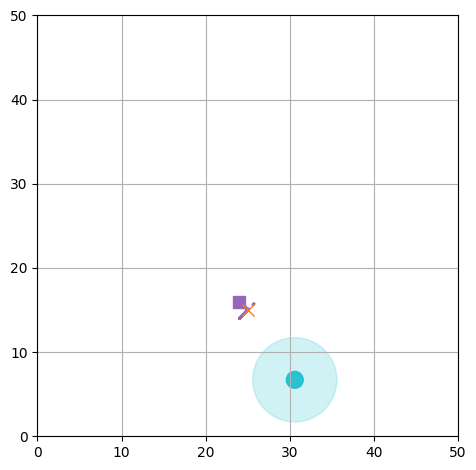

In [13]:
plot_joint_trajectory(
    joint_traj_dir=frozen_uav_trajs_dir / 'traj_0.csv',
    individual_colors=False,
    no_shading=False,
    plot_args=PlotArgs()
)

In [14]:
# Go through each joint trajectory, but freeze the uav in place

freeze_uav_dfs = []
for traj_df in traj_dfs:
    # Get the individual agent and poi configs within the config
    rover_config = config['env']['agents']['rovers'][0]
    uav_config = config['env']['agents']['uavs'][0]
    poi_config = config['env']['pois']['hidden_pois'][0]

    # Set up the rover's neural network policy
    rover_nn = NeuralNetwork(
        num_inputs=12,
        num_hidden=[15],
        num_outputs=2,
        hidden_activation_func='tanh',
        output_activation_func='tanh'
    )
    rover_nn.setWeights(elite_team[0])

    # Now resim for 50 steps, but the uav is staying still
    resim_freeze_uav_eval_info = resim_env(
        num_steps = 50,
        rover_config = rover_config,
        uav_config = uav_config,
        poi_config = poi_config,
        poi_position = [
            float(traj_df['hidden_poi_0_x'][0]),
            float(traj_df['hidden_poi_0_y'][0])
        ],
        uav_position = uav_config['position']['fixed'],
        rover_position = rover_config['position']['fixed'],
        uav_action = [0., 0.],
        rover_action = None,
        uav_policy_function = None,
        rover_policy_function = rover_nn
    )

    freeze_uav_dfs.append(build_traj_df(resim_freeze_uav_eval_info))

In [15]:
# Save all of the frozen dfs

# this awkward naming scheme is necessary for plotting tools
frozen_uav_trajs_dir = save_dir / 'frozen_uav' / 'traj' / 'traj'
if not os.path.exists(frozen_uav_trajs_dir):
    os.makedirs(frozen_uav_trajs_dir)

# save the trajectories
df_dirs = [frozen_uav_trajs_dir / ('traj_'+str(i)+'.csv') for i in range(len(traj_dfs))]
for df_dir, df in zip(df_dirs, freeze_uav_dfs):
    df.to_csv(df_dir, index=False)

# Save config
config_dir = save_dir / 'frozen_uav' / 'config.yaml'
with open(config_dir, "w") as file:
    yaml.dump(config, file, default_flow_style=False)


In [16]:
# Save plots of all the joint trajectories from the frozen dfs
base_out_dir = Path(os.path.expanduser('~')) / 'influence-shaping' / 'outfigs' / '02_19_2025' / '01_influence' / 'frozen_uav'
for df_dir in df_dirs:
    plot_joint_trajectory(
        joint_traj_dir=df_dir,
        individual_colors=False,
        no_shading=False,
        plot_args=PlotArgs(
            output=base_out_dir / (df_dir.name+'.png')
        )
    )

In [17]:
# Let's look at the joint probability distribution of actions normally vs when the uav is frozen
dxs = []
dys = []
for traj_df in traj_dfs:
    dx = traj_df['rover_0_dx'].to_list()
    dy = traj_df['rover_0_dy'].to_list()
    dxs += dx
    dys += dy

freeze_uav_dxs = []
freeze_uav_dys = []
for traj_df in freeze_uav_dfs:
    dx = traj_df['rover_0_dx'].to_list()
    dy = traj_df['rover_0_dy'].to_list()
    freeze_uav_dxs += dx
    freeze_uav_dys += dy

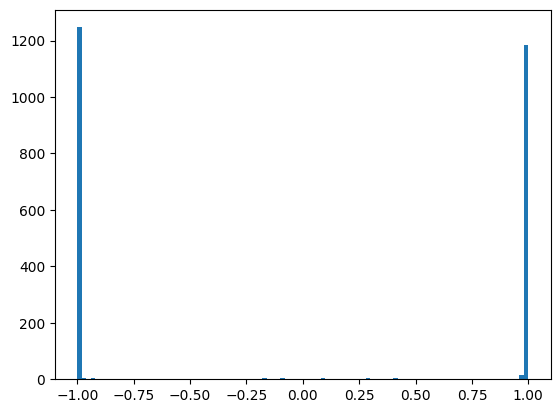

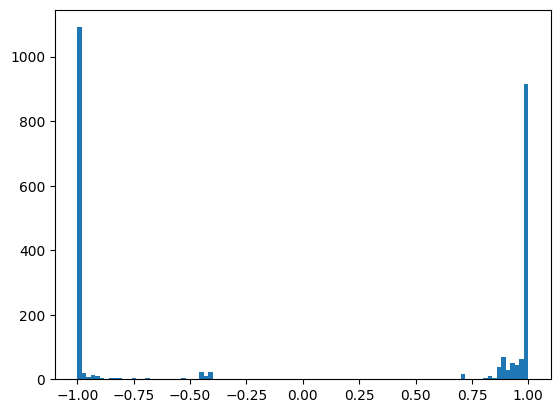

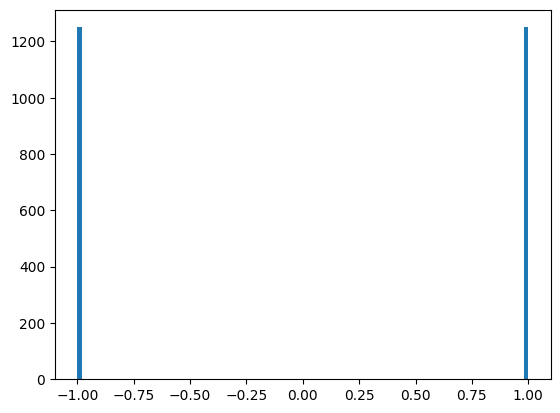

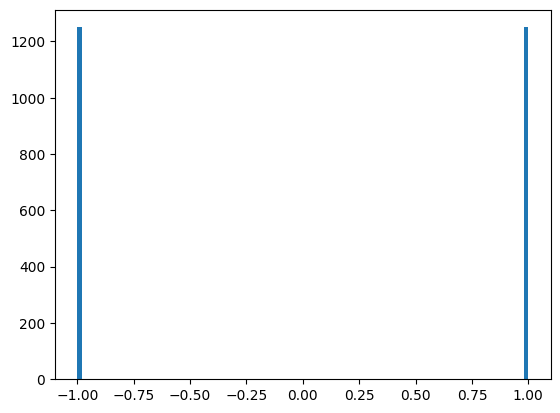

In [18]:
# Plotting histograms
plt.hist(dxs, bins=100);
plt.show()
plt.hist(dys, bins=100);
plt.show()
plt.hist(freeze_uav_dxs, bins=100);
plt.show()
plt.hist(freeze_uav_dys, bins=100);
plt.show()

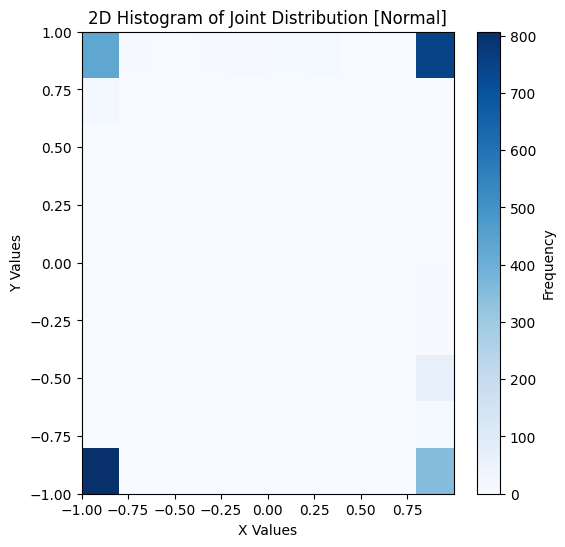

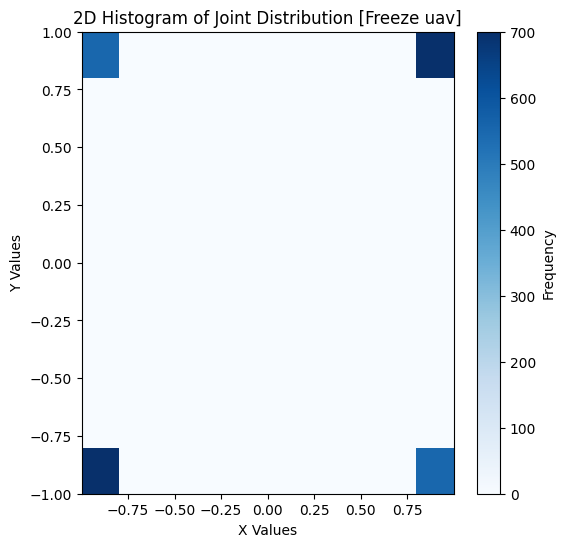

In [19]:
# Create 2D Histogram
num_bins = 10

plt.figure(figsize=(6, 6))
plt.hist2d(dxs, dys, bins=num_bins, cmap='Blues')

# Add color bar
plt.colorbar(label='Frequency')

# Labels and title
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('2D Histogram of Joint Distribution [Normal]')

plt.show()

plt.figure(figsize=(6, 6))
plt.hist2d(freeze_uav_dxs, freeze_uav_dys, bins=num_bins, cmap='Blues')

# Add color bar
plt.colorbar(label='Frequency')

# Labels and title
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('2D Histogram of Joint Distribution [Freeze uav]')

plt.show()

In [20]:
# There are only minor differences in actions. What about states?
xs = []
ys = []
for traj_df in traj_dfs:
    xs += traj_df['rover_0_x'].to_list()
    ys += traj_df['rover_0_y'].to_list()

freeze_uav_xs = []
freeze_uav_ys = []
for traj_df in freeze_uav_dfs:
    freeze_uav_xs += traj_df['rover_0_x'].to_list()
    freeze_uav_ys += traj_df['rover_0_y'].to_list()

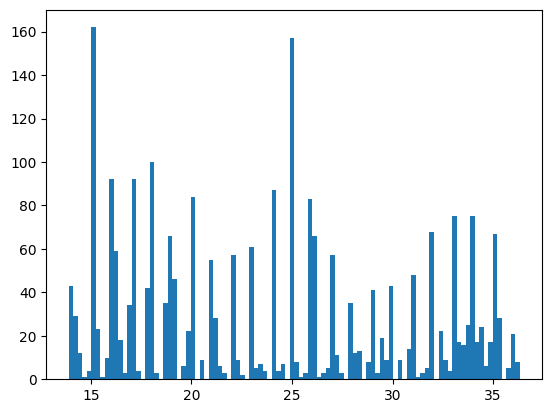

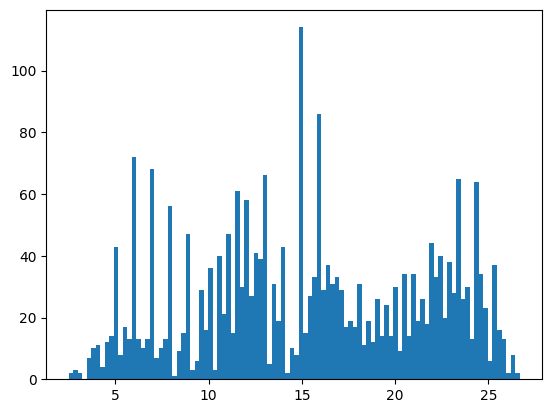

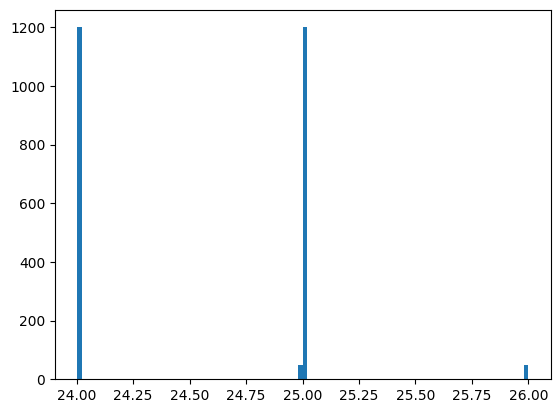

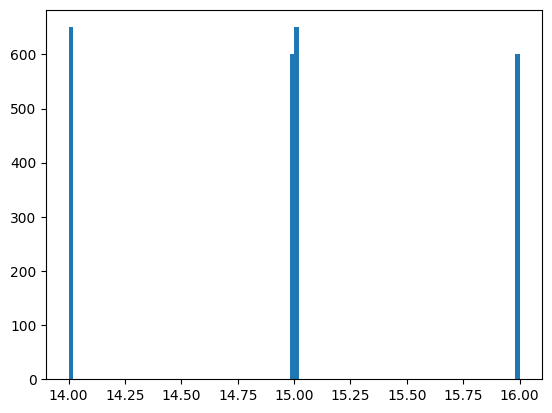

In [21]:
# Plotting histograms
plt.hist(xs, bins=100);
plt.show()
plt.hist(ys, bins=100);
plt.show()
plt.hist(freeze_uav_xs, bins=100);
plt.show()
plt.hist(freeze_uav_ys, bins=100);
plt.show()

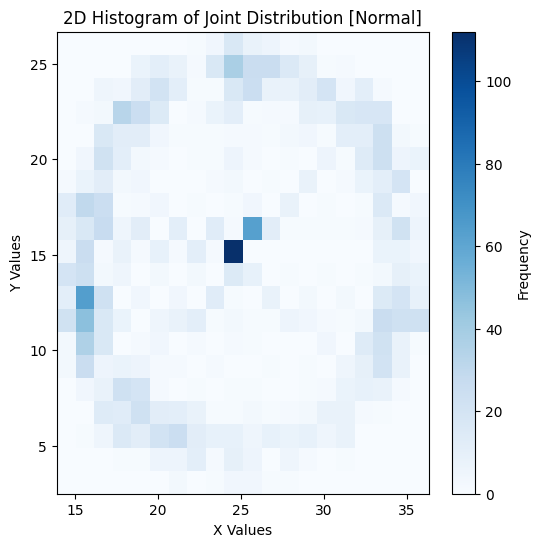

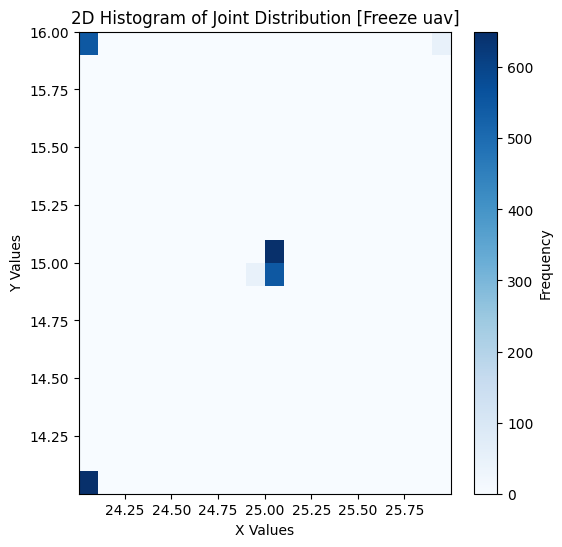

In [22]:
# Create 2D Histogram
num_bins = 20

plt.figure(figsize=(6, 6))
plt.hist2d(xs, ys, bins=num_bins, cmap='Blues')

# Add color bar
plt.colorbar(label='Frequency')

# Labels and title
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('2D Histogram of Joint Distribution [Normal]')

plt.show()

plt.figure(figsize=(6, 6))
plt.hist2d(freeze_uav_xs, freeze_uav_ys, bins=num_bins, cmap='Blues')

# Add color bar
plt.colorbar(label='Frequency')

# Labels and title
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('2D Histogram of Joint Distribution [Freeze uav]')

plt.show()

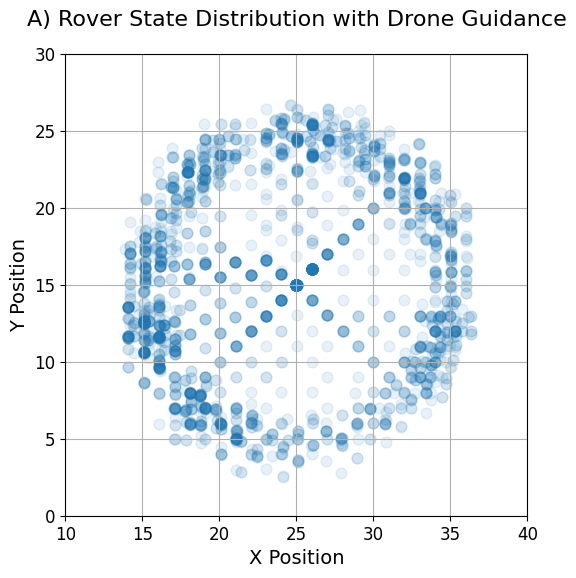

In [23]:
# Create 2D Histogram

# Add jitter (small random noise)
jitter_strength = 0.  # Adjust this value for more/less jitter
x_jittered = xs + np.random.normal(0, jitter_strength, size=len(xs))
y_jittered = ys + np.random.normal(0, jitter_strength, size=len(ys))

fig, ax = plt.subplots(1,1, figsize=(6, 6))
ax.grid()
# Adjust size and alpha to reveal more data points that overlap or fall closely together
ax.scatter(x_jittered, y_jittered, s=60, alpha=.1, color='tab:blue')

# Labels and title
ax.set_xlabel('X Position', font_properties=font_manager.FontProperties(size=14))
ax.set_ylabel('Y Position', font_properties=font_manager.FontProperties(size=14))
ax.tick_params(axis='both', labelsize=12)  # Use desired font size (e.g., 14)
ax.set_title('A) Rover State Distribution with Drone Guidance', font_properties=font_manager.FontProperties(size=16), pad=20)

ax.axis('square')
ax.set_xlim([10,40])
ax.set_ylim([0,30])

fig.savefig(save_fig_dir / 'rover_state_dist.svg')

# fig.tight_layout()

# fig.show()

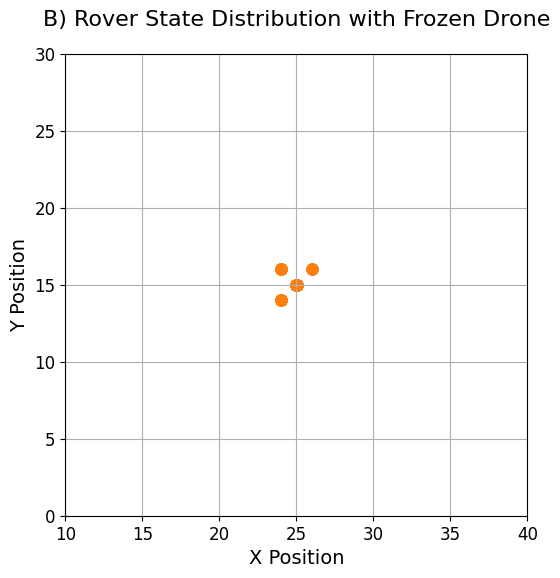

In [24]:
# Create 2D Histogram

# Add jitter (small random noise)
jitter_strength = 0.  # Adjust this value for more/less jitter
x_jittered = freeze_uav_xs + np.random.normal(0, jitter_strength, size=len(xs))
y_jittered = freeze_uav_ys + np.random.normal(0, jitter_strength, size=len(ys))

fig, ax = plt.subplots(1,1, figsize=(6, 6))
ax.grid()
# Adjust size and alpha to reveal more data points that overlap or fall closely together
ax.scatter(x_jittered, y_jittered, s=60, alpha=.1, color='tab:orange')

# Labels and title
ax.set_xlabel('X Position', font_properties=font_manager.FontProperties(size=14))
ax.set_ylabel('Y Position', font_properties=font_manager.FontProperties(size=14))
ax.tick_params(axis='both', labelsize=12)
ax.set_title('B) Rover State Distribution with Frozen Drone', font_properties=font_manager.FontProperties(size=16), pad=20)

ax.axis('square')
ax.set_xlim([10,40])
ax.set_ylim([0,30])

fig.savefig(save_fig_dir / 'rover_state_dist_frozen_drone.svg')

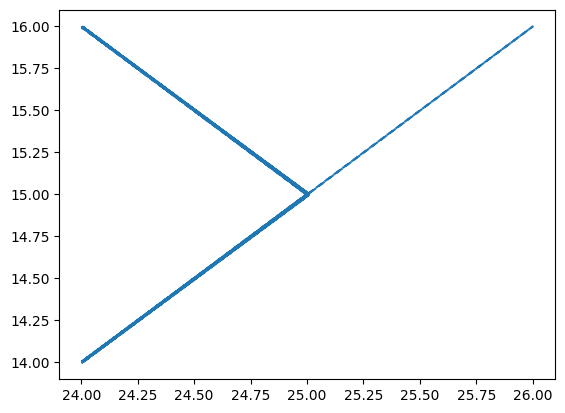

In [25]:
# freeze_uav_dfs[0]
plt.plot(freeze_uav_dfs[0]['rover_0_x'], freeze_uav_dfs[0]['rover_0_y'], '--')

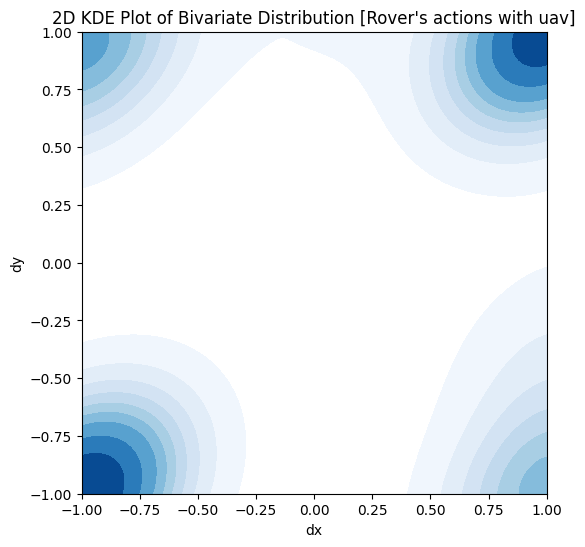

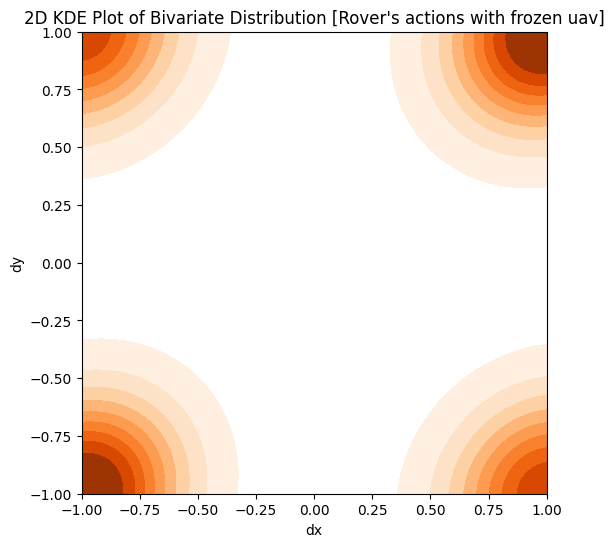

In [26]:
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.kdeplot(x=dxs, y=dys, cmap='Blues', fill=True)

# Labels and title
plt.xlabel('dx')
plt.ylabel('dy')
plt.title('2D KDE Plot of Bivariate Distribution [Rover\'s actions with uav]')

plt.xlim([-1, 1])
plt.ylim([-1, 1])

plt.show()

plt.figure(figsize=(6, 6))
sns.kdeplot(x=freeze_uav_dxs, y=freeze_uav_dys, cmap='Oranges', fill=True)

# Labels and title
plt.xlabel('dx')
plt.ylabel('dy')
plt.title('2D KDE Plot of Bivariate Distribution [Rover\'s actions with frozen uav]')

plt.xlim([-1, 1])
plt.ylim([-1, 1])

plt.show()

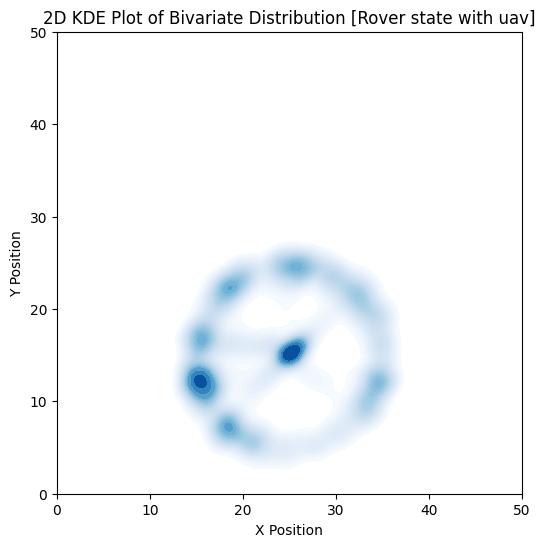

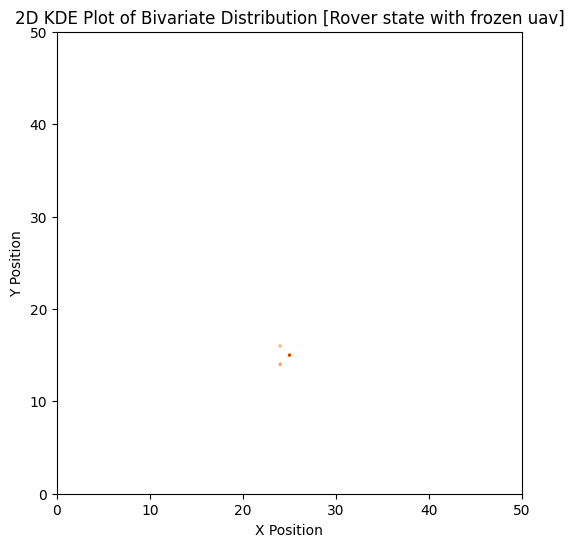

In [27]:
import seaborn as sns

gridsize = 100
bw_adjust = .5
levels = 30

plt.figure(figsize=(6, 6))
sns.kdeplot(x=xs, y=ys, cmap='Blues', fill=True,
            bw_adjust=bw_adjust, gridsize=gridsize, levels=levels
            )

# Labels and title
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('2D KDE Plot of Bivariate Distribution [Rover state with uav]')

plt.xlim([0, 50])
plt.ylim([0, 50])

plt.show()

plt.figure(figsize=(6, 6))
sns.kdeplot(x=freeze_uav_xs, y=freeze_uav_ys, cmap='Oranges', fill=True,
             bw_adjust=bw_adjust, gridsize=gridsize, levels=levels
             )

# Labels and title
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('2D KDE Plot of Bivariate Distribution [Rover state with frozen uav]')

plt.xlim([0, 50])
plt.ylim([0, 50])

plt.show()

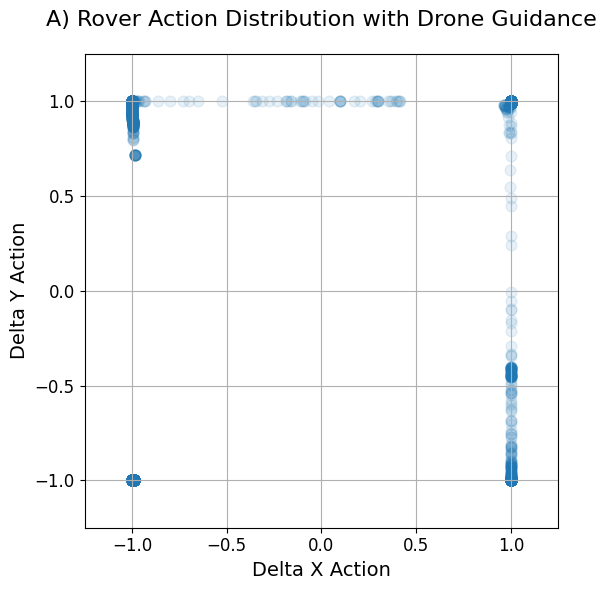

In [28]:
# Create 2D Histogram

# Add jitter (small random noise)
jitter_strength = 0.  # Adjust this value for more/less jitter
x_jittered = dxs + np.random.normal(0, jitter_strength, size=len(dxs))
y_jittered = dys + np.random.normal(0, jitter_strength, size=len(dys))

fig, ax = plt.subplots(1,1, figsize=(6, 6))
ax.grid()
# Adjust size and alpha to reveal more data points that overlap or fall closely together
ax.scatter(x_jittered, y_jittered, s=60, alpha=.1, color='tab:blue')

# Labels and title
ax.set_xlabel('Delta X Action', font_properties=font_manager.FontProperties(size=14))
ax.set_ylabel('Delta Y Action', font_properties=font_manager.FontProperties(size=14))
ax.tick_params(axis='both', labelsize=12)  # Use desired font size (e.g., 14)
ax.set_title('A) Rover Action Distribution with Drone Guidance', font_properties=font_manager.FontProperties(size=16), pad=20)

ax.axis('square')
ax.set_xlim([-1.25, 1.25])
ax.set_ylim([-1.25,1.25])

fig.tight_layout()

fig.savefig(save_fig_dir / 'rover_action_dist.svg')

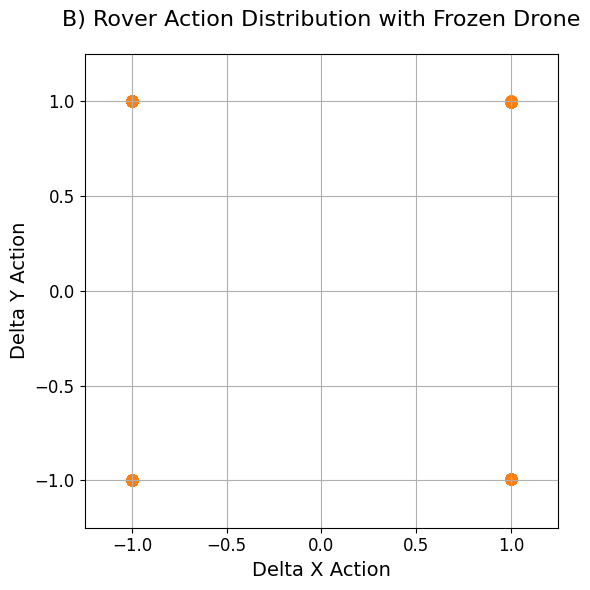

In [29]:
# Create 2D Histogram

# Add jitter (small random noise)
jitter_strength = 0.  # Adjust this value for more/less jitter
x_jittered = freeze_uav_dxs + np.random.normal(0, jitter_strength, size=len(dxs))
y_jittered = freeze_uav_dys + np.random.normal(0, jitter_strength, size=len(dys))

fig, ax = plt.subplots(1,1, figsize=(6, 6))
ax.grid()
# Adjust size and alpha to reveal more data points that overlap or fall closely together
ax.scatter(x_jittered, y_jittered, s=60, alpha=.1, color='tab:orange')

# Labels and title
ax.set_xlabel('Delta X Action', font_properties=font_manager.FontProperties(size=14))
ax.set_ylabel('Delta Y Action', font_properties=font_manager.FontProperties(size=14))
ax.tick_params(axis='both', labelsize=12)  # Use desired font size (e.g., 14)
ax.set_title('B) Rover Action Distribution with Frozen Drone', font_properties=font_manager.FontProperties(size=16), pad=20)

ax.axis('square')
ax.set_xlim([-1.25, 1.25])
ax.set_ylim([-1.25,1.25])

fig.tight_layout()

fig.savefig(save_fig_dir / 'rover_action_dist_frozen_drone.svg')

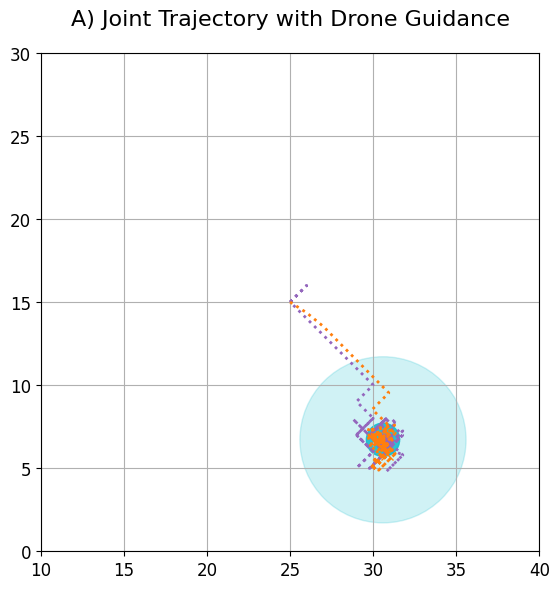

In [30]:
traj_dir = Path(os.path.expanduser('~')) / 'influence-shaping' / 'results' / '02_19_2025' / '01_influence' / 'original' / 'traj' / 'traj' / 'traj_0.csv'

fig = generate_joint_trajectory_plot(
    joint_traj_dir=traj_dir,
    individual_colors=False,
    no_shading=False,
    plot_args=PlotArgs(
        xlim=[10,40],
        ylim = [0,30]
    )
)

fig.set_size_inches(6,6)

ax = fig.axes[0]

ax.tick_params(axis='both', labelsize=12)
ax.set_title('A) Joint Trajectory with Drone Guidance', font_properties=font_manager.FontProperties(size=16), pad=20)
fig.tight_layout()

fig.savefig(save_fig_dir / 'joint_traj_0_normal.svg')

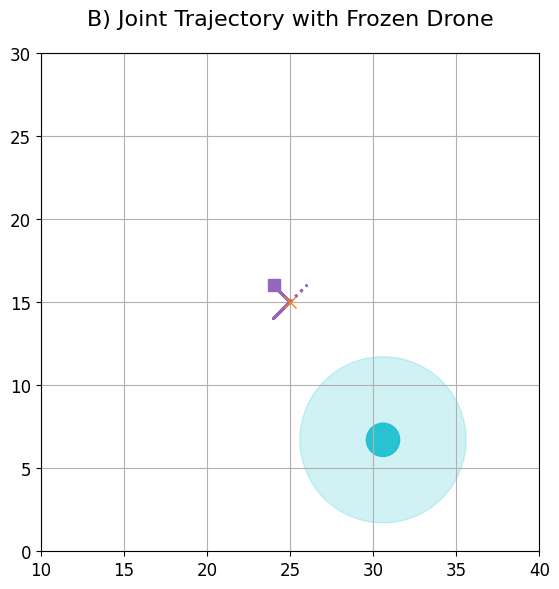

In [31]:
traj_dir = Path(os.path.expanduser('~')) / 'influence-shaping' / 'results' / '02_19_2025' / '01_influence' / 'frozen_uav' / 'traj' / 'traj' / 'traj_0.csv'

fig = generate_joint_trajectory_plot(
    joint_traj_dir=traj_dir,
    individual_colors=False,
    no_shading=False,
    plot_args=PlotArgs(
        xlim=[10,40],
        ylim = [0,30]
    )
)

fig.set_size_inches(6,6)

ax = fig.axes[0]

ax.tick_params(axis='both', labelsize=12)
ax.set_title('B) Joint Trajectory with Frozen Drone', font_properties=font_manager.FontProperties(size=16), pad=20)
fig.tight_layout()

fig.savefig(save_fig_dir / 'joint_traj_0_frozen_drone.svg')

In [32]:
# save to csv
df_ = pd.DataFrame({
    "dxs": dxs,
    "dys": dys,
    "f_dxs": freeze_uav_dxs,
    "f_dys": freeze_uav_dys
})
df_.to_csv(save_dir/"actions.csv")

In [33]:
# At a coarse level it is clear that the uav has a strong influence on the state of the rover,
# but it's hard to tell anything from looking at the rover's actions.

# What about at a fine-grained level? What if we freeze

In [34]:
import scipy

In [35]:
# does ordering matter for computing KL Divergence?
# https://medium.com/%40hosamedwee/kullback-leibler-kl-divergence-with-examples-part-2-9123bff5dc10#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjkxNGZiOWIwODcxODBiYzAzMDMyODQ1MDBjNWY1NDBjNmQ0ZjVlMmYiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMTY0OTY0Nzg3Mzk1MzA0MzUxMzkiLCJlbWFpbCI6ImV2ZXJnb245MDdAZ21haWwuY29tIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsIm5iZiI6MTc0MTk5MzEwMCwibmFtZSI6IkV2ZXJhcmRvIEdvbnphbGV6IiwicGljdHVyZSI6Imh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FDZzhvY0tCTnNTOXU3NVVMR19rUEJMTzk4eWNSMHQ0dVlzcFd0MWRUd3owMzJBdUhRa2Q1Zz1zOTYtYyIsImdpdmVuX25hbWUiOiJFdmVyYXJkbyIsImZhbWlseV9uYW1lIjoiR29uemFsZXoiLCJpYXQiOjE3NDE5OTM0MDAsImV4cCI6MTc0MTk5NzAwMCwianRpIjoiNzQ4Y2MwYzk0YjhkNmM5YzFjZjdkNThhN2E1NTRjNjM1NzQxMzI3NyJ9.zTFEKn3488FO8F2jk2xdQfgJOHGZXBmn0OwrmnkYFvCJuBuYkQOOx3IsU73-zOkmsnKwsZhMEosytvCArqooi5HSQfQs9Qe1Td-PFlzpbjFeIwwHUpz2yZsM4nE7BAQ2tIPYr1oaPpUX58XKtBlPztt473zj3tJDl5NsNZiN3ZoQGm_zd6ndN5IF8VH1lCaHmH1WFPwOfUUQvnNVRg-RSCPR3_yAISvOXPtxWSgXRkgz4mgiBuE8RAtogWnlit58PM9gkngTKW-l4uH2BWcgUxgJpl5lXPEPGVys7lDyfAKDjcWnQnmp6etz38CcOep0SoqFn-fmcg_WlIjGYveWZQ
# This medium article mentions this idea that we are measuring the distance between a true distribution and an approximated one
# (which is not really what I'm doing)
# KL Divergence is NOT SYMMETRIC, so it actually does matter which distribution we treat as the true distribution vs which is the approx. one

import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde, entropy

# Define the data
data = {
    "dxs": [1.000000, -0.996973, 0.999000, 0.998998, 0.998995, 0.998993, 0.998992, -0.997402, 0.998986, -0.997475, 1.000000, -0.999915, 0.998914, -0.999949, 1.000000, -0.998821, 0.999491, 1.000000, 0.363406, -0.995216],
    "dys": [1.000000, -1.000000, -0.998114, -0.998108, -0.998103, -0.998098, -0.998094, -1.000000, -0.998080, -1.000000, 0.992939, -1.000000, -0.997743, -1.000000, 0.992943, 0.984127, -0.993400, 0.992945, 0.999999, -1.000000],
    "f_dxs": [1.000000, -0.997513, -0.999466, 1.000000, -0.999845, 0.999625, -0.999466, 1.000000, -0.999845, 0.999622, -0.999466, 1.000000, -0.999845, 0.999619, -0.999466, 1.000000, -0.999845, 0.999617, -0.999466, 1.000000],
    "f_dys": [1.000000, -1.000000, -1.000000, 0.993449, 0.999997, -0.991496, -1.000000, 0.993455, 0.999997, -0.991547, -1.000000, 0.993461, 0.999997, -0.991597, -1.000000, 0.993466, 0.999997, -0.991645, -1.000000, 0.993472]
}

df = pd.DataFrame(data)

# Extract (dx, dy) and (f_dx, f_dy) pairs
data1 = df[['dxs', 'dys']].values.T  # First distribution
data2 = df[['f_dxs', 'f_dys']].values.T  # Second distribution

# Estimate probability densities using kernel density estimation (KDE)
kde1 = gaussian_kde(data1)
kde2 = gaussian_kde(data2)

# Evaluate densities at the given sample points
p1 = kde1(data1)
p2 = kde2(data1)  # Evaluating f-distribution on the dxs sample points

# Normalize to ensure valid probability distributions
p1 /= p1.sum()
p2 /= p2.sum()

# Compute KL divergence
kl_divergence = entropy(p2, p1)

print(f"KL Divergence: {kl_divergence}")
print(p1)


KL Divergence: 0.10723519570617668
[0.03708461 0.04903016 0.06531548 0.06531548 0.06531549 0.06531549
 0.0653155  0.04902981 0.06531551 0.04902975 0.0370776  0.04902722
 0.06531577 0.04902718 0.0370776  0.00878885 0.06531588 0.03707761
 0.02619368 0.04903132]


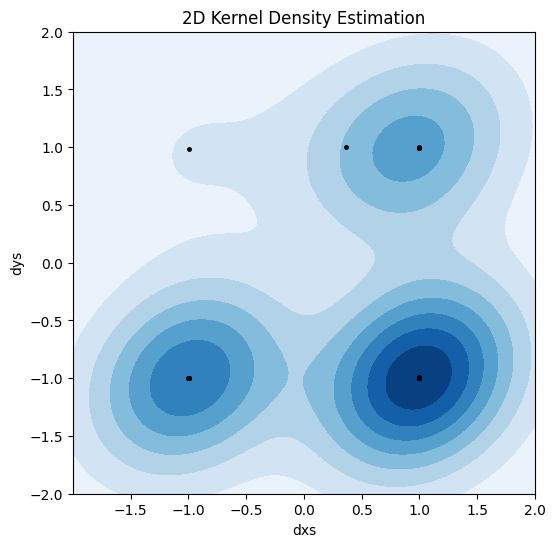

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Define the data
data = {
    "dxs": [1.000000, -0.996973, 0.999000, 0.998998, 0.998995, 0.998993, 0.998992, -0.997402, 0.998986, -0.997475,
            1.000000, -0.999915, 0.998914, -0.999949, 1.000000, -0.998821, 0.999491, 1.000000, 0.363406, -0.995216],
    "dys": [1.000000, -1.000000, -0.998114, -0.998108, -0.998103, -0.998098, -0.998094, -1.000000, -0.998080, -1.000000,
            0.992939, -1.000000, -0.997743, -1.000000, 0.992943, 0.984127, -0.993400, 0.992945, 0.999999, -1.000000]
}

df = pd.DataFrame(data)

# Extract (dx, dy) pairs
data_points = df[['dxs', 'dys']].values.T

# Perform Kernel Density Estimation
kde = gaussian_kde(data_points)

# Create grid for plotting
x_min, x_max = data_points[0].min() - 1, data_points[0].max() + 1
y_min, y_max = data_points[1].min() - 1, data_points[1].max() + 1
x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([x.ravel(), y.ravel()])
density = np.reshape(kde(positions).T, x.shape)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
cfset = ax.contourf(x, y, density, cmap='Blues')
ax.imshow(np.rot90(density), cmap='Blues', extent=[x_min, x_max, y_min, y_max])
ax.plot(data_points[0], data_points[1], 'k.', markersize=5)
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_xlabel('dxs')
ax.set_ylabel('dys')
ax.set_title('2D Kernel Density Estimation')
plt.show()


In [37]:
# Focus on a single joint trajectory of a high-performing team
# And at each step, simulate a counterfactual action from the uav where it stays still
# Measure the distance between the rover's normal action and its new response action
# Maybe even plot this over time

# Get the individual agent and poi configs within the config
rover_config = config['env']['agents']['rovers'][0]
uav_config = config['env']['agents']['uavs'][0]
poi_config = config['env']['pois']['hidden_pois'][0]

# Set up the rover's neural network policy
rover_nn = NeuralNetwork(
    num_inputs=12,
    num_hidden=[15],
    num_outputs=2,
    hidden_activation_func='tanh',
    output_activation_func='tanh'
)
rover_nn.setWeights(elite_team[0])

eval_infos = []
for t, row in enumerate(traj_dfs[0].itertuples(index=False)):
    # Simulate a counterfactual action from the uav
    resim_eval_info = resim_env(
        num_steps=2,
        rover_config=rover_config,
        uav_config=uav_config,
        poi_config=poi_config,
        poi_position=[
            float(row.hidden_poi_0_x),
            float(row.hidden_poi_0_y)
        ],
        uav_position=[
            float(row.uav_0_x),
            float(row.uav_0_y)
        ],
        rover_position=[
            float(row.rover_0_x),
            float(row.rover_0_y)
        ],
        uav_action=[0., 0.],
        rover_action=None,
        uav_policy_function=None,
        rover_policy_function=rover_nn
    )
    eval_infos.append(resim_eval_info)

In [38]:
short_traj_dfs = [build_traj_df(eval_info) for eval_info in eval_infos]

In [94]:
short_traj_dfs[0]['rover_0_dx'][1] == traj_dfs[0]['rover_0_dx'][1]

np.False_

In [98]:
traj_dfs[0]

rover_0_x  rover_0_y    uav_0_x    uav_0_y  hidden_poi_0_x  \
0   25.000000  15.000000  25.000000  15.000000       30.590752   
1   26.000000  16.000000  26.000000  14.350511       30.590752   
2   25.003027  15.000000  26.999999  13.531967       30.590752   
3   26.002027  14.001886  27.982835  12.531967       30.590752   
4   27.001025  13.003779  28.967756  11.531968       30.590752   
5   28.000020  12.005676  29.954483  10.531968       30.590752   
6   28.999013  11.007578  30.942728   9.531969       30.590752   
7   29.998005  10.009484  29.942728   8.531981       30.590752   
8   29.000603   9.009484  30.942728   7.574738       30.590752   
9   29.999589   8.011403  29.942728   6.574750       30.590752   
10  29.002114   7.011403  30.942724   7.574750       30.590752   
11  30.002114   8.004343  29.942731   7.308953       30.590752   
12  29.002199   7.004343  30.942730   6.351553       30.590752   
13  30.001113   6.006600  29.942757   5.354437       30.590752   
14  29.001164   5.006600  30.942753   6.354437       30.590752   
15  30.001164   5.999544  29.942753   7.353301       30.590752   
16  29.002342   6.983671  30.320225   6.353301       30.590752   
17  30.001833   5.990271  31.320224   7.350553       30.590752   
18  31.001833   6.983215  30.320231   7.086389       30.590752   
19  31.365239   7.983215  30.640724   6.086389       30.590752   
20  30.370023   6.983215  29.640987   7.086351       30.590752   
21  30.762207   7.983214  29.915010   6.086351       30.590752   
22  29.767279   6.983214  30.915006   7.086351       30.590752   
23  30.767279   7.978885  29.915013   6.821661       30.590752   
24  29.769803   6.978885  30.915012   5.855301       30.590752   
25  30.768976   5.982980  29.915041   4.857928       30.590752   
26  29.771461   4.982980  30.915038   5.857928       30.590752   
27  30.771461   5.976340  29.915038   6.856708       30.590752   
28  29.772876   6.970394  30.294376   5.856708       30.590752   
29  30.772814   6.000812  31.294375   6.853994       30.590752   
30  31.772814   6.999333  30.294382   6.593783       30.590752   
31  30.775526   5.999333  31.294379   7.593783       30.590752   
32  31.775526   6.992339  30.294385   7.333818       30.590752   
33  30.776814   7.959090  30.715372   6.333818       30.590752   
34  29.779771   6.959090  29.715627   7.333782       30.590752   
35  28.780051   7.959090  29.928318   6.333782       30.590752   
36  29.778962   6.961441  30.928318   7.330997       30.590752   
37  30.778961   7.956342  29.928325   7.068878       30.590752   
38  29.781223   6.956342  30.928324   6.104913       30.590752   
39  30.780796   5.963987  29.928353   5.107600       30.590752   
40  29.783034   4.963987  30.928349   6.107600       30.590752   
41  30.783034   5.957036  29.928349   7.106426       30.590752   
42  29.784224   6.933518  30.329749   6.106426       30.590752   
43  30.784223   6.248288  31.329748   7.103725       30.590752   
44  31.784222   7.246548  30.329755   6.845123       30.590752   
45  30.786882   6.246548  31.329755   5.875689       30.590752   
46  31.786882   5.794930  30.329787   4.878076       30.590752   
47  30.790156   4.794930  31.329784   5.878076       30.590752   
48  31.790155   5.789797  30.329784   6.876812       30.590752   
49  30.792377   6.714409  30.823658   5.876812       30.590752   

    hidden_poi_0_y  rover_0_dx  rover_0_dy  uav_0_dx  uav_0_dy  ...  \
0         6.708831    1.000000    1.000000  1.000000 -0.649489  ...   
1         6.708831   -0.996973   -1.000000  1.000000 -0.818544  ...   
2         6.708831    0.999000   -0.998114  0.982836 -1.000000  ...   
3         6.708831    0.998998   -0.998108  0.984920 -1.000000  ...   
4         6.708831    0.998995   -0.998103  0.986727 -1.000000  ...   
5         6.708831    0.998993   -0.998098  0.988246 -1.000000  ...   
6         6.708831    0.998992   -0.998094 -1.000000 -0.999988  ...   
7         6.708831   -0.997402   -1.000000  1.000000 -0.957243  ...  

In [75]:
# First let's collect rover actions
rover_actions = np.array([np.array([row.rover_0_dx, row.rover_0_dy]) for row in traj_dfs[0].itertuples(index=False)][1:])

# Then let's collect counterfactual rover actions
cfac_actions = np.array([np.array([df['rover_0_dx'][1], df['rover_0_dy'][1]]) for df in short_traj_dfs][:-1])

In [76]:
rover_actions[0]

array([-0.99697271, -0.99999999])

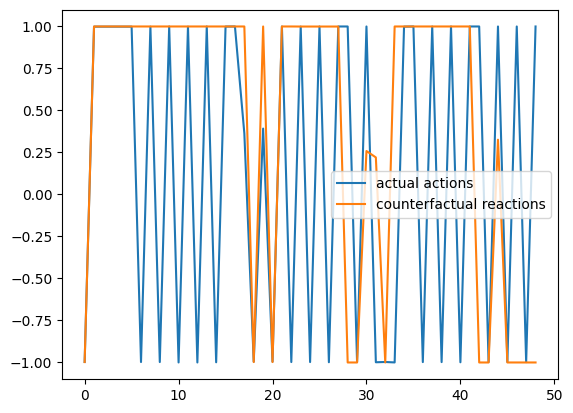

In [42]:
# Let's compare dxs and counterfactual dxs
fig, ax = plt.subplots(1,1)
ax.plot(rover_actions[:,0], 'tab:blue', label='actual actions')
ax.plot(cfac_actions[:,0], 'tab:orange', label='counterfactual reactions')
ax.legend()

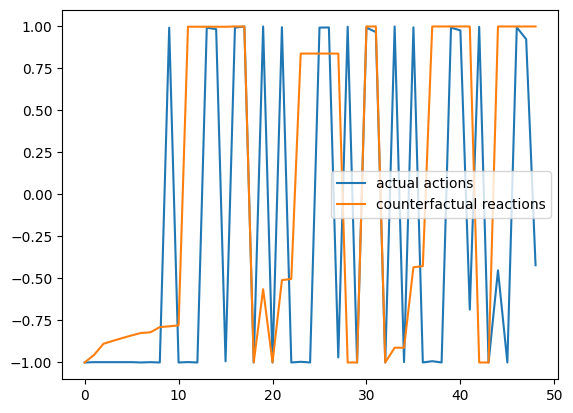

In [43]:
# Let's compare dxs and counterfactual dys
fig, ax = plt.subplots(1,1)
ax.plot(rover_actions[:,1], 'tab:blue', label='actual actions')
ax.plot(cfac_actions[:,1], 'tab:orange', label='counterfactual reactions')
ax.legend()

Text(0.5, 1.0, 'Distance between actual and c-fac rover actions')

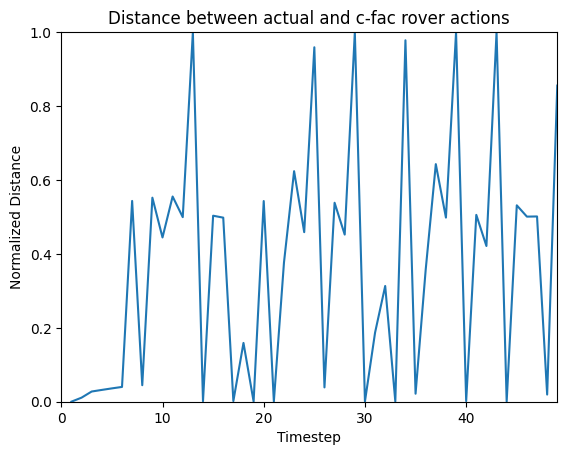

In [100]:
# Running a normalization on the difference between rover reaction to uav and counterfactual reaction
steps = np.arange(49)+1
rover_dist = np.mean(np.abs( (cfac_actions-rover_actions)/2 ) , axis=1)
fig, ax = plt.subplots(1,1)
ax.plot(steps,rover_dist)

ax.set_xlim([0,49])
ax.set_ylim([0,1])

ax.set_ylabel("Normalized Distance")
ax.set_xlabel("Timestep")

ax.set_title("Distance between actual and c-fac rover actions")


# Certain points in time stand out where the rover's action changes drastically as a result of the uav's influence
# like there are key points of influence that stand out

Text(0.5, 1.0, 'Distance between actual and c-fac uav actions')

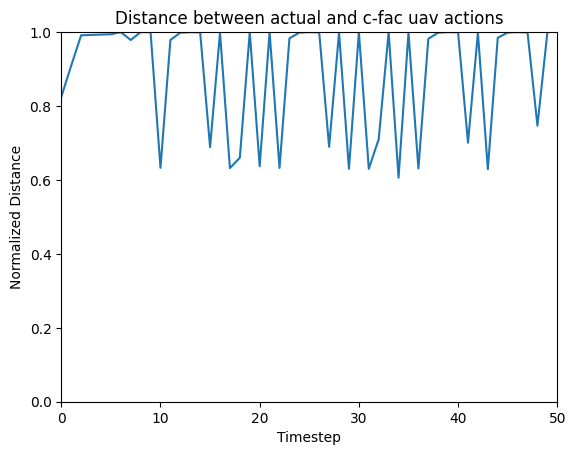

In [101]:
# What happens if I look at how different the uav's action is from its counterfactual action

# First let's collect uav actions (the one it took before the rover was fed a counterfactual scenario with the uav)
uav_actions = np.array([np.array([row.uav_0_dx, row.uav_0_dy]) for row in traj_dfs[0].itertuples(index=False)])

# Then let's collect counterfactual rover actions
uav_cfac_actions = np.array([np.array([0, 0]) for _ in uav_actions])

# Let's do the same distance measurement but with the uav
steps = np.arange(50)
uav_dist = np.mean(np.abs( (uav_cfac_actions-uav_actions)/1 ) , axis=1)
fig, ax = plt.subplots(1,1)
ax.plot(steps,uav_dist)

ax.set_xlim([0,50])
ax.set_ylim([0,1])

ax.set_ylabel("Normalized Distance")
ax.set_xlabel("Timestep")

ax.set_title("Distance between actual and c-fac uav actions")


In [103]:
len(uav_cfac_actions)

50

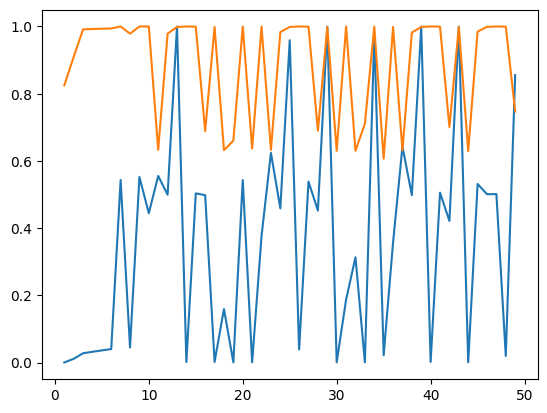

In [46]:
# What if I plot them together?

fig, ax = plt.subplots(1,1)
ax.plot(steps, rover_dist)
ax.plot(steps, uav_dist)

In [47]:
# steps, rover_dist
rover_dist[rover_dist >= 0.9]

array([0.99960508, 0.95899099, 0.9996302 , 0.97795635, 0.99944025,
       0.99956497])

/tmp/ipykernel_8014/3996632920.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


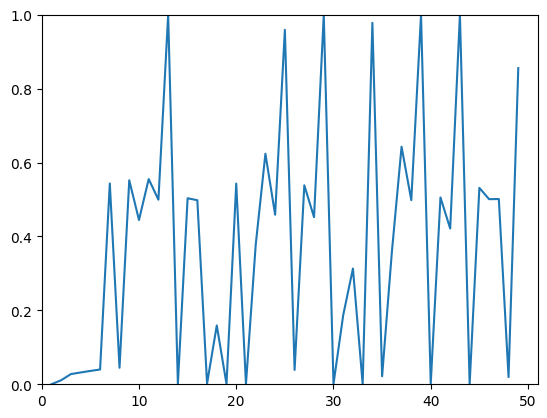

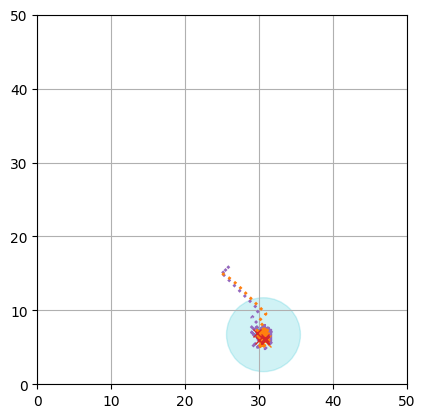

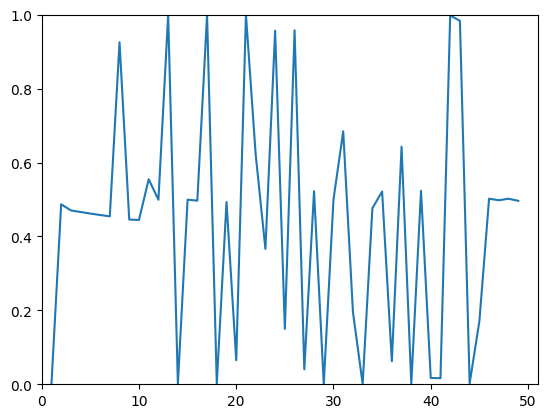

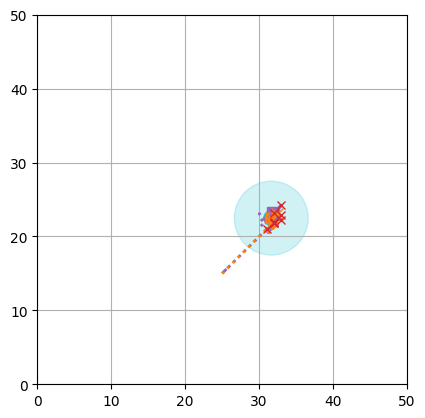

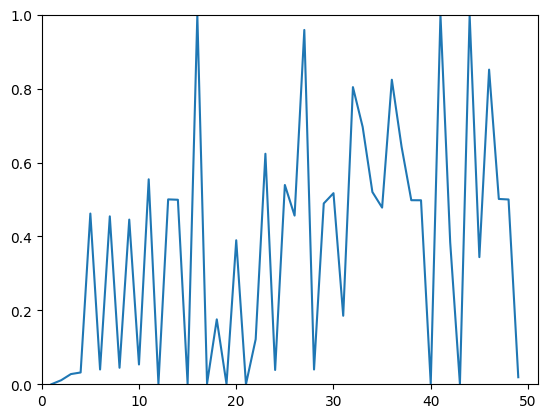

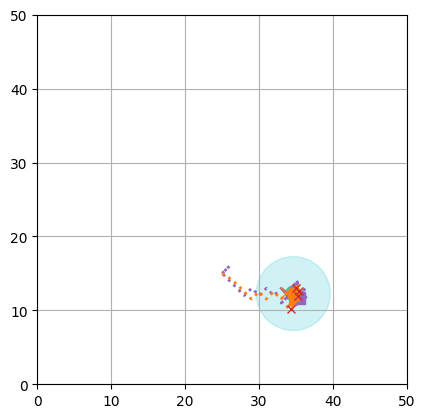

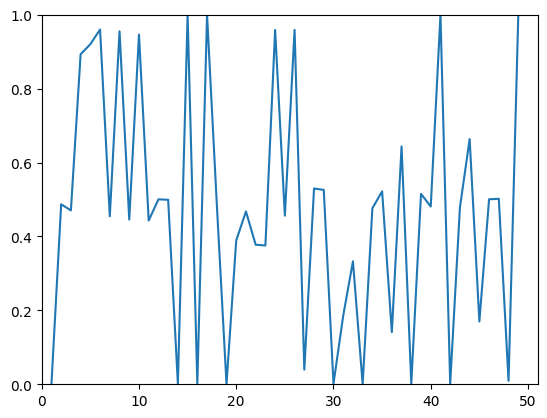

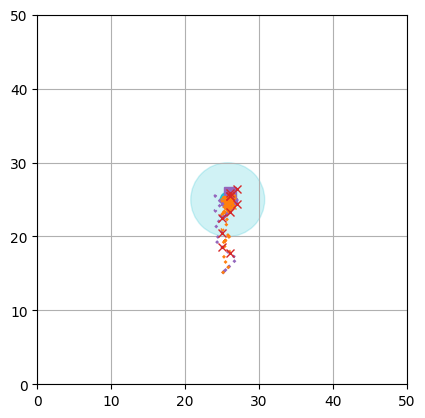

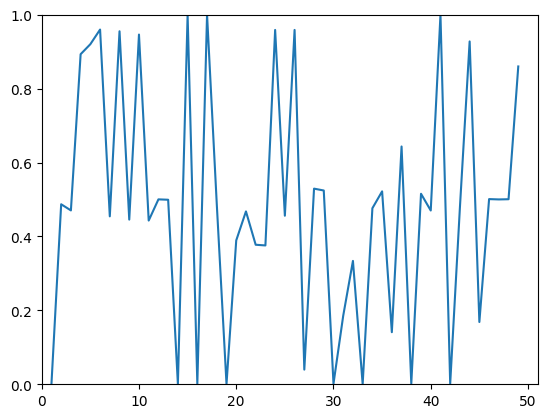

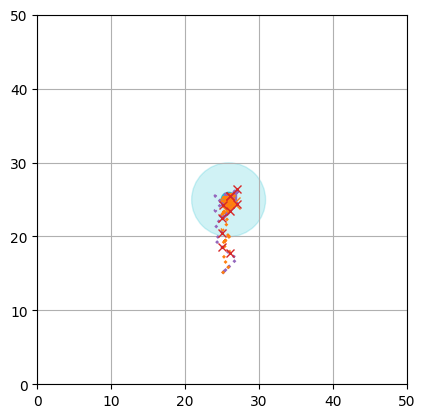

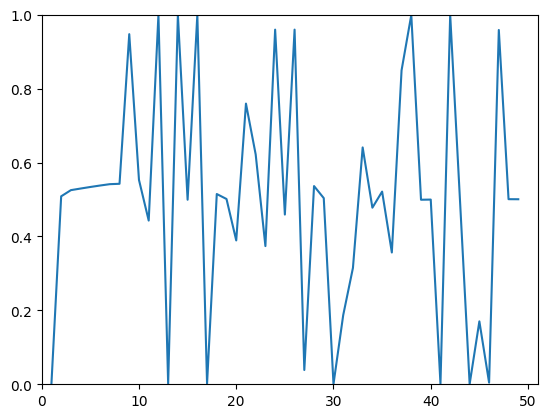

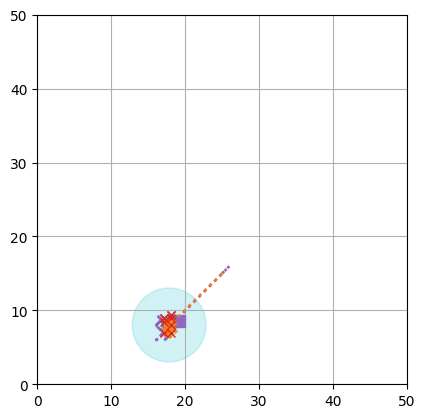

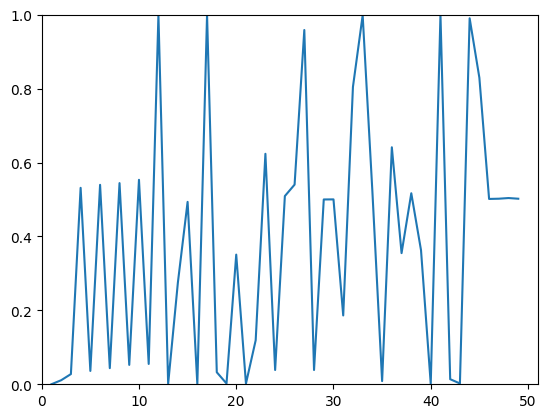

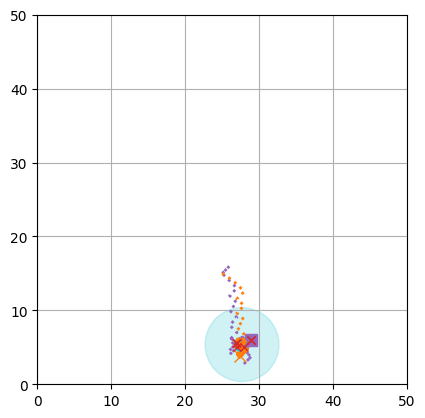

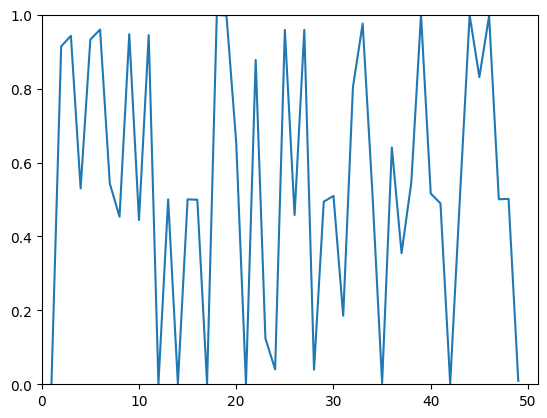

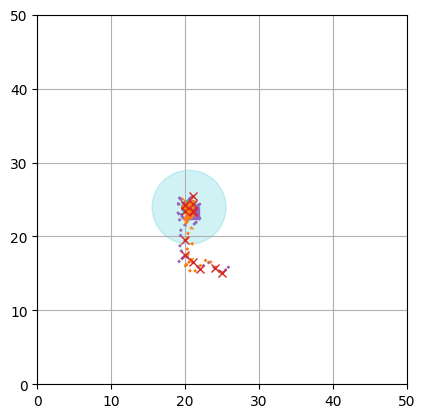

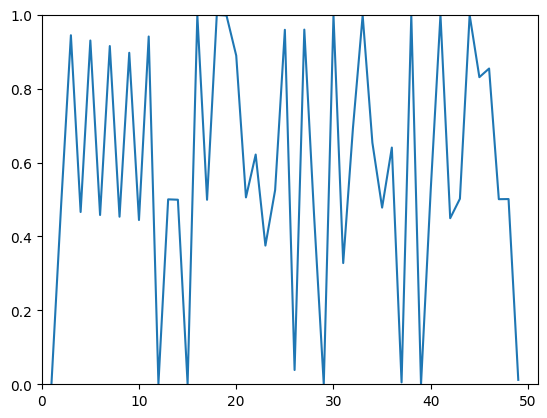

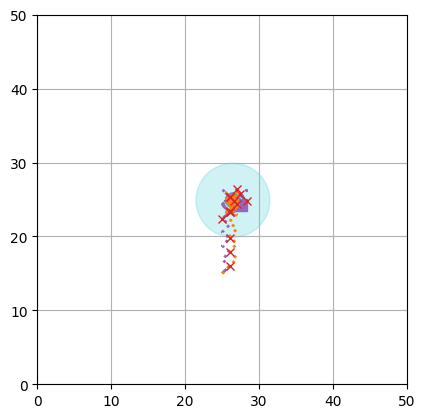

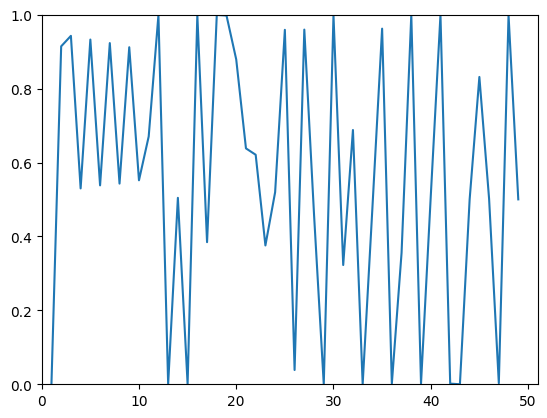

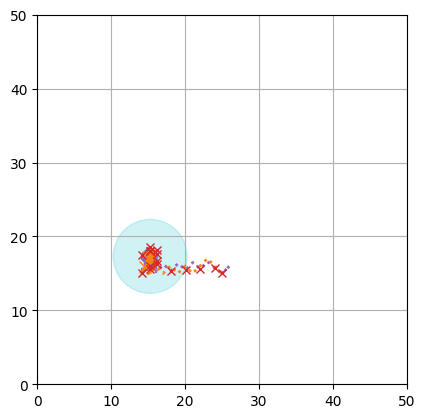

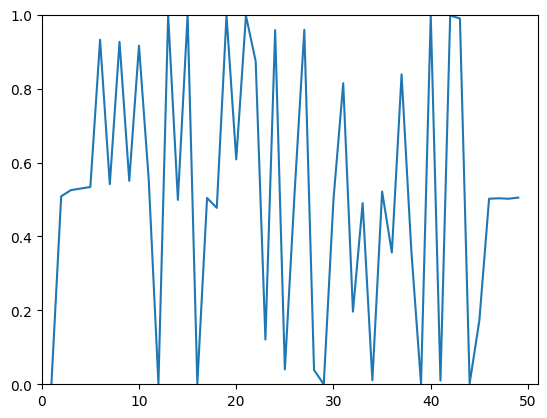

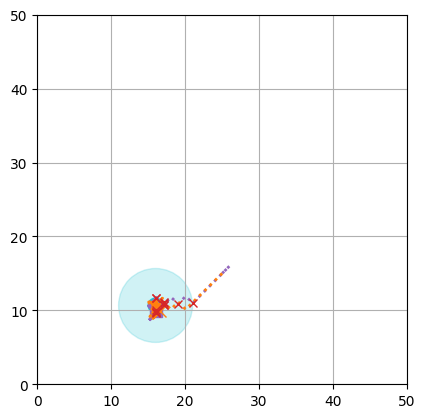

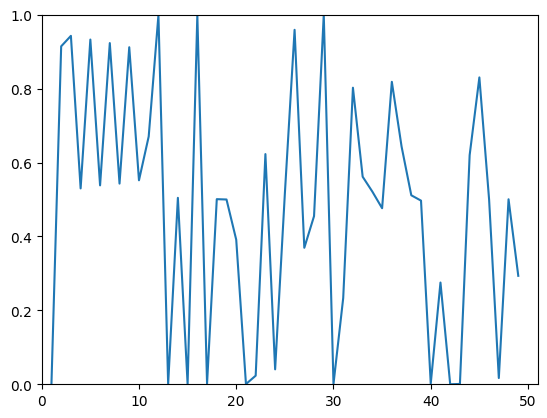

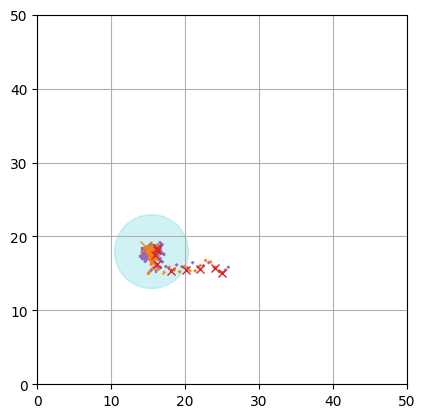

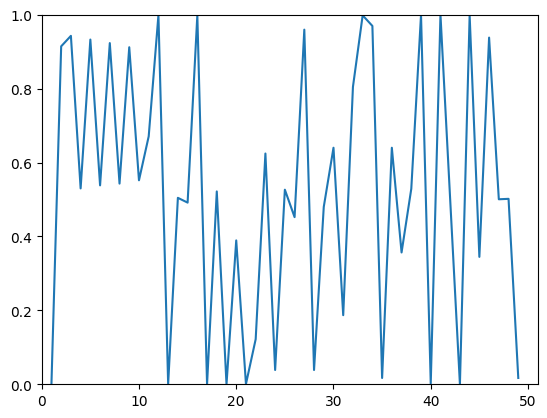

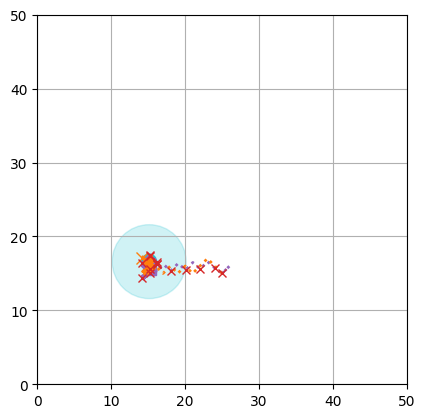

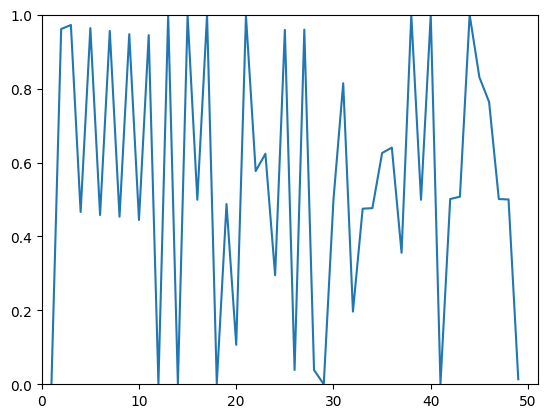

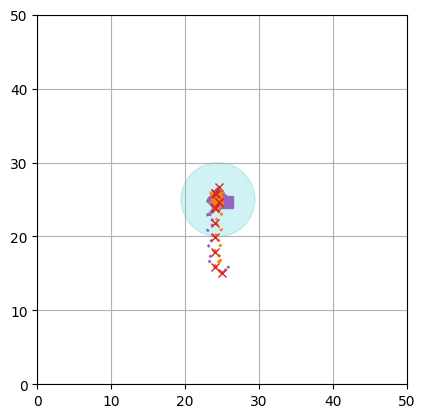

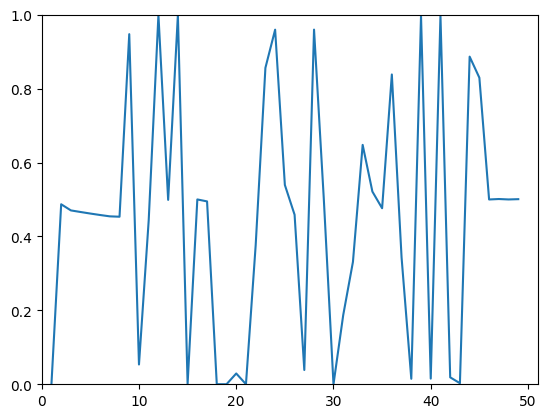

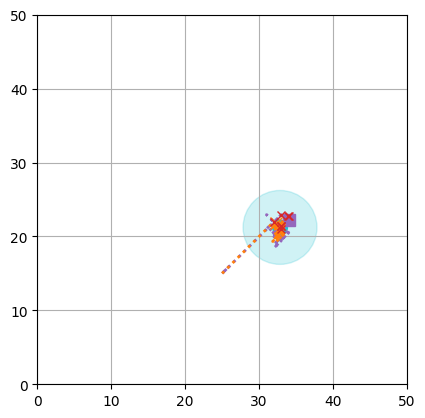

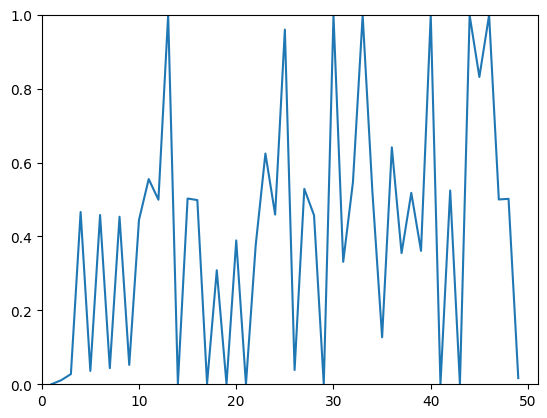

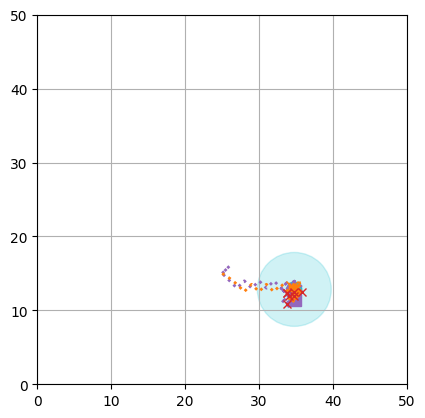

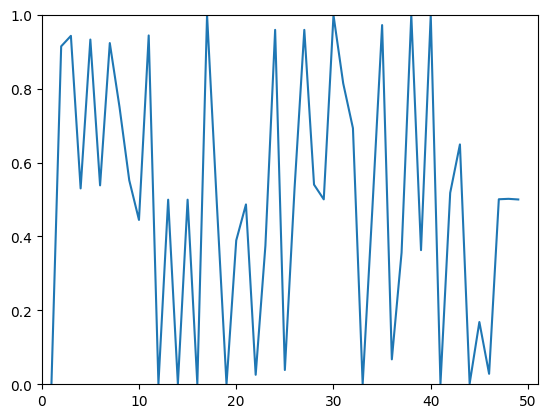

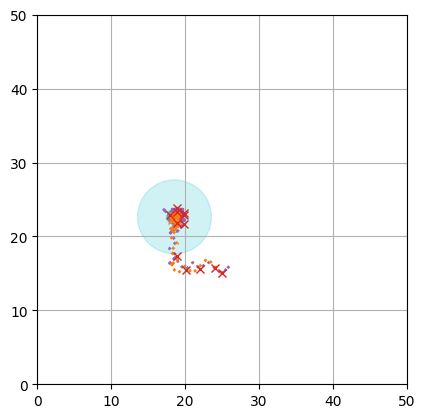

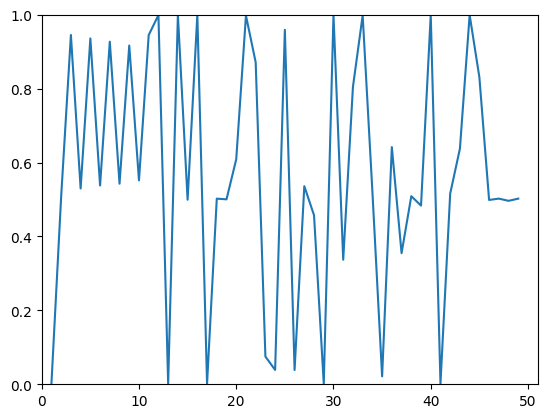

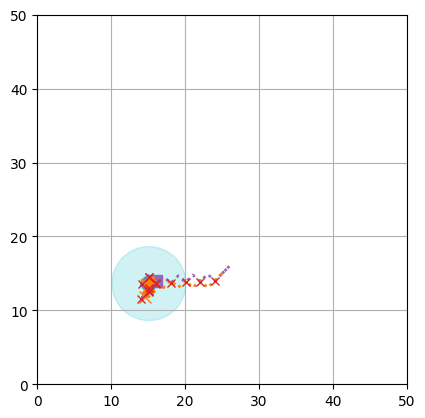

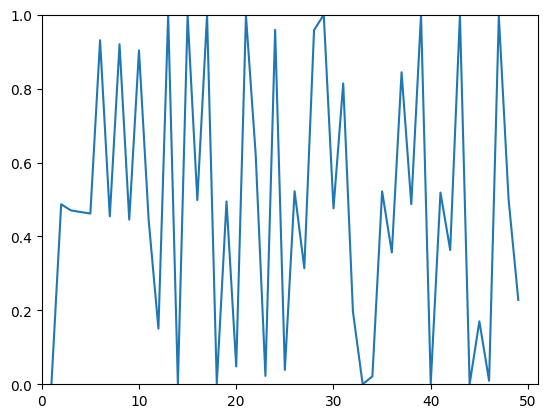

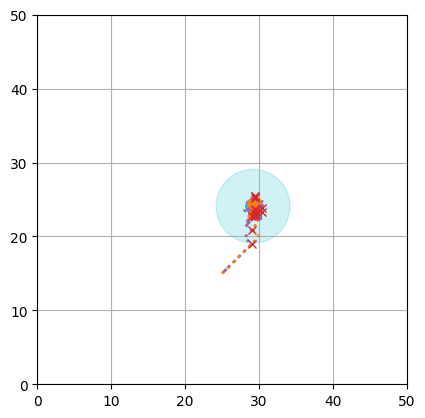

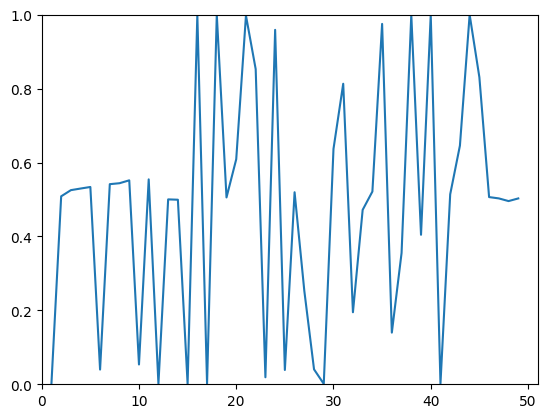

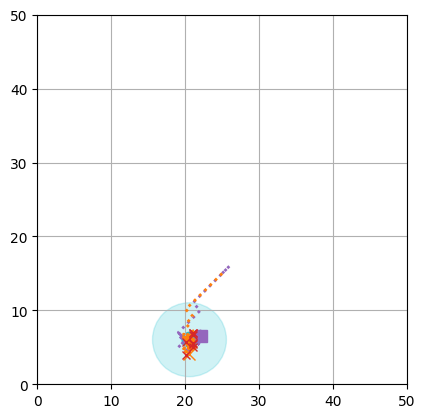

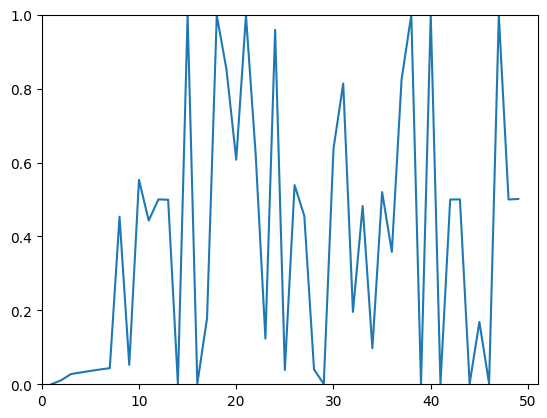

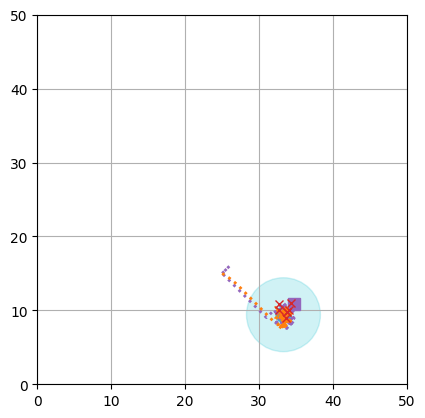

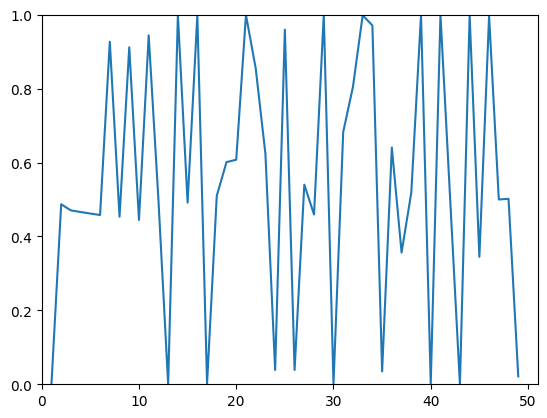

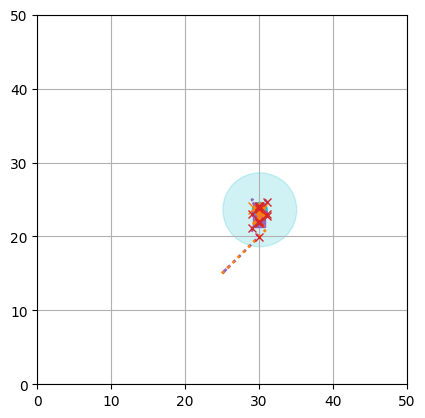

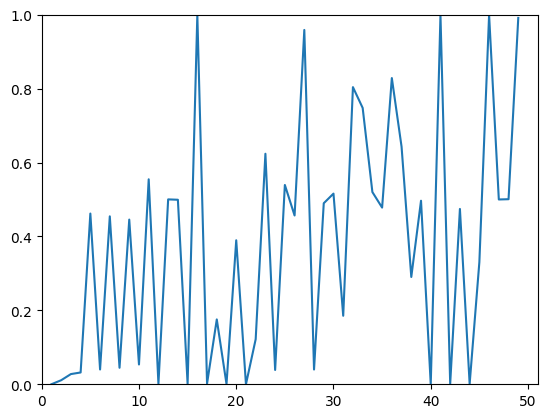

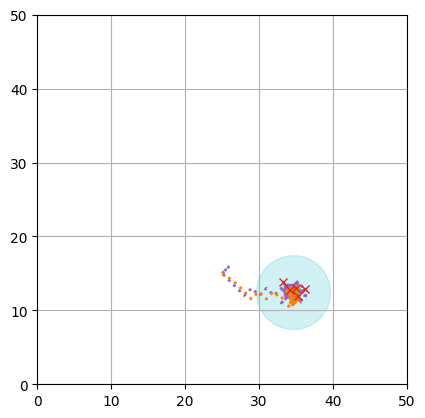

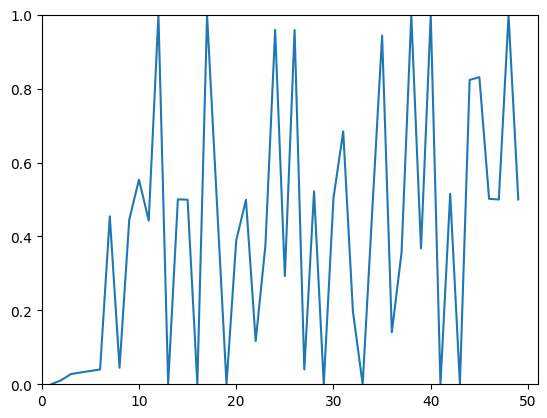

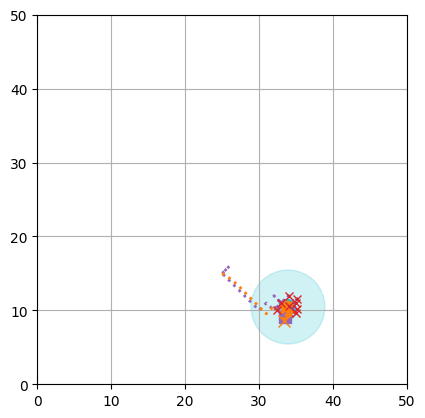

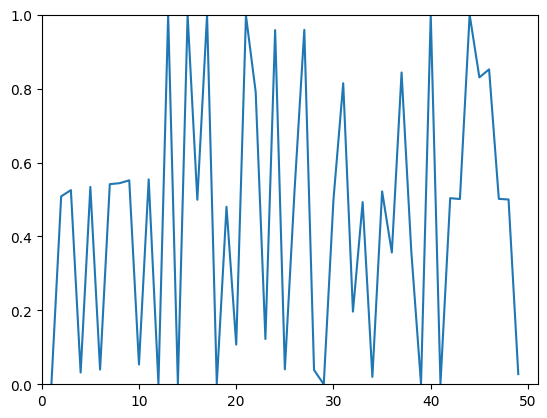

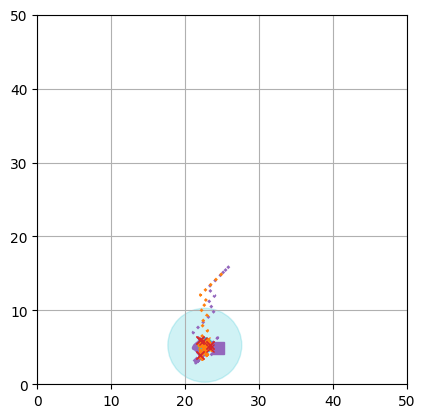

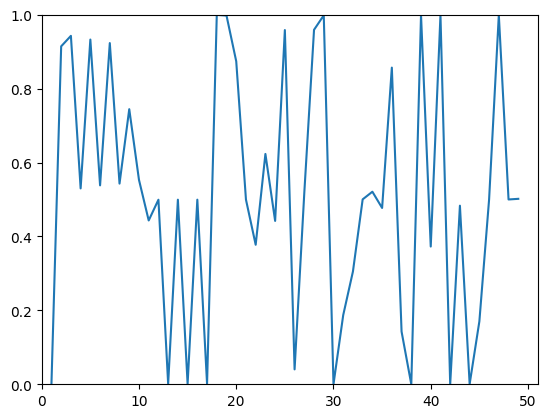

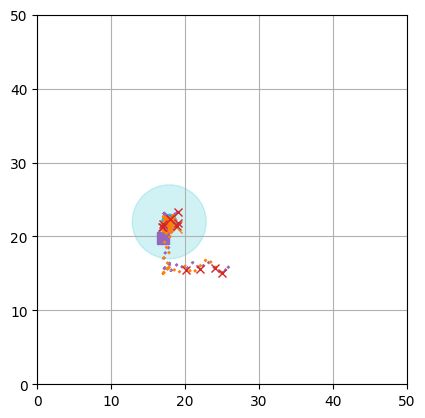

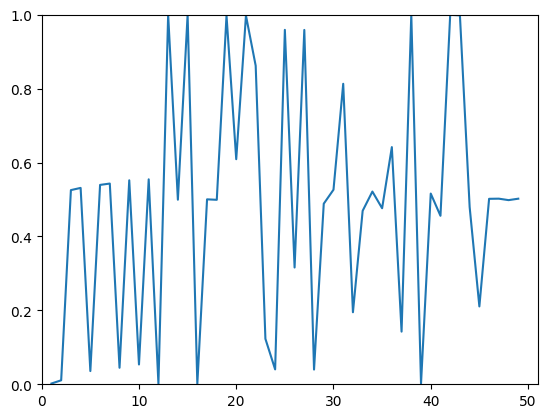

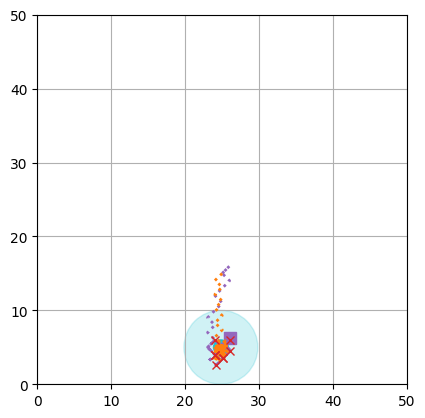

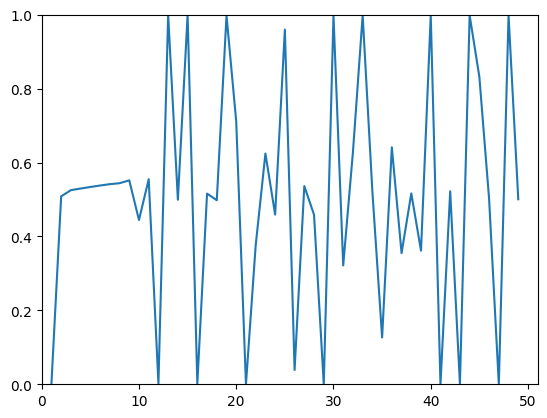

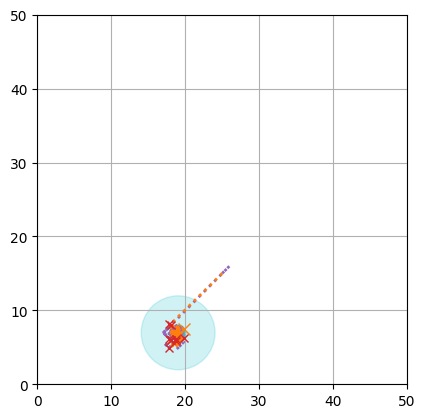

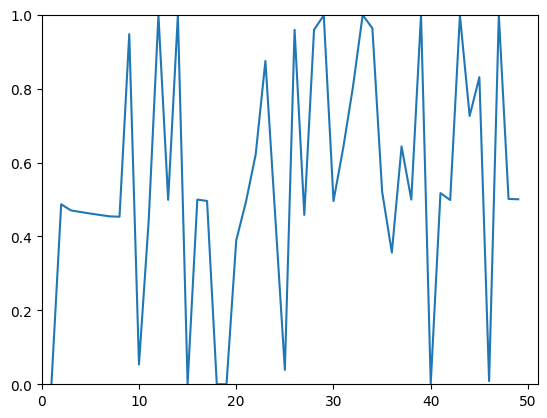

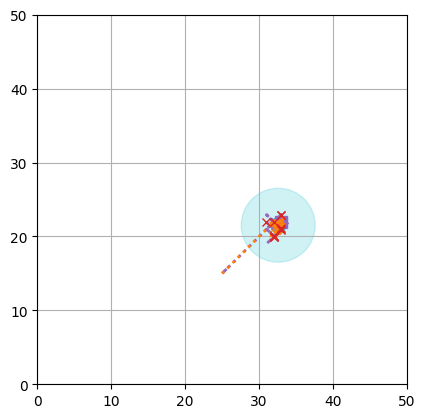

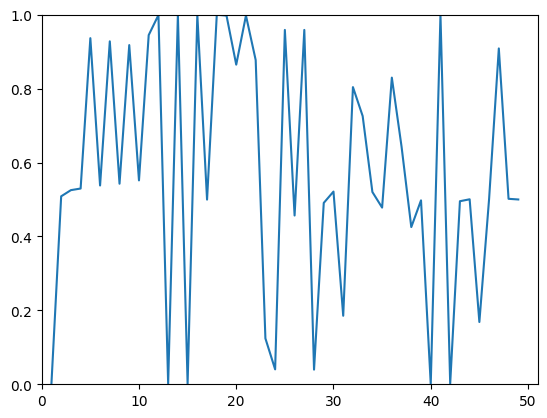

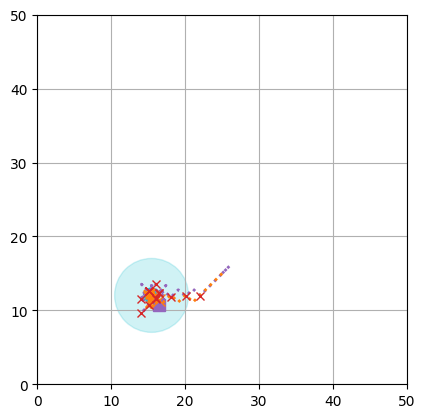

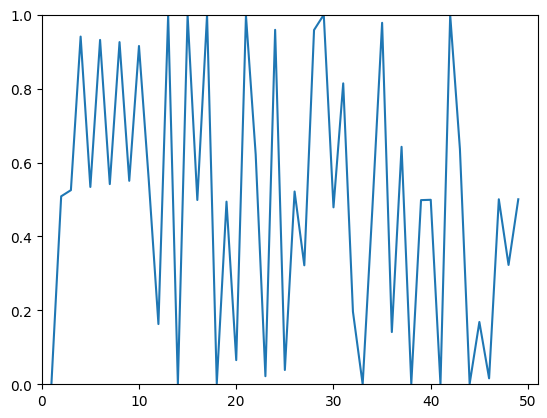

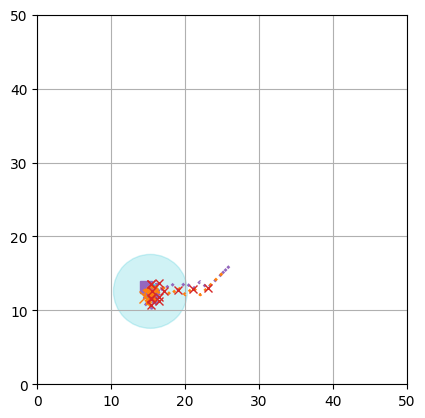

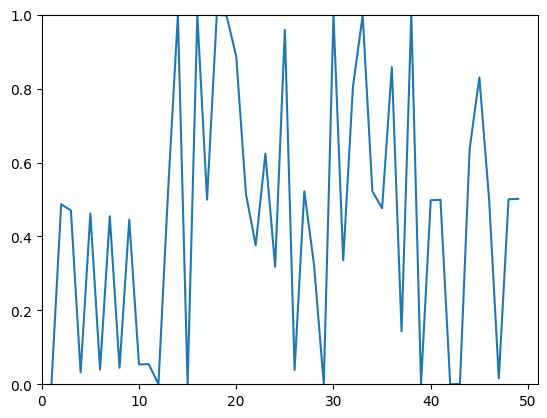

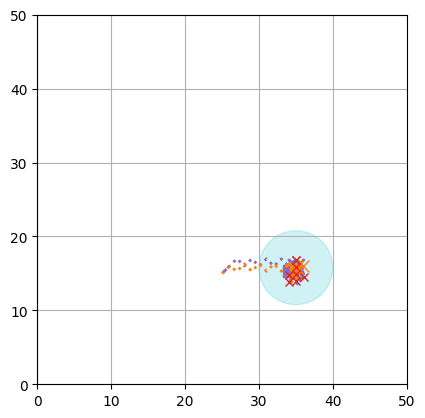

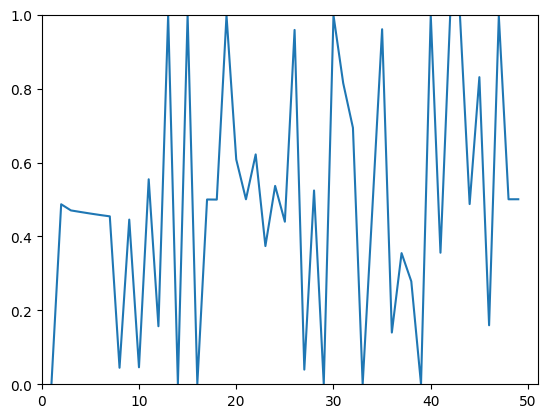

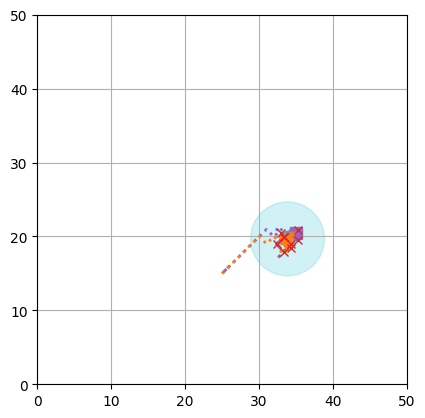

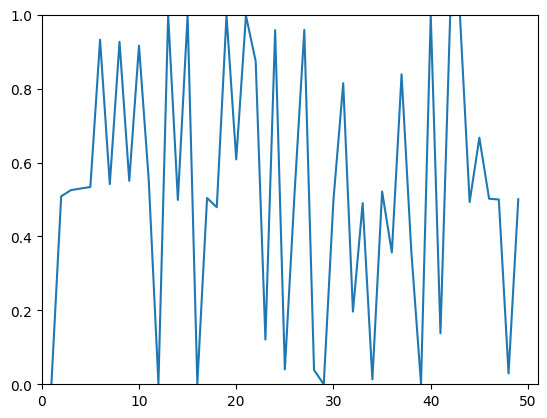

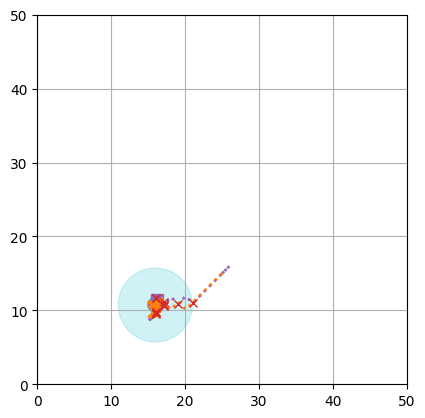

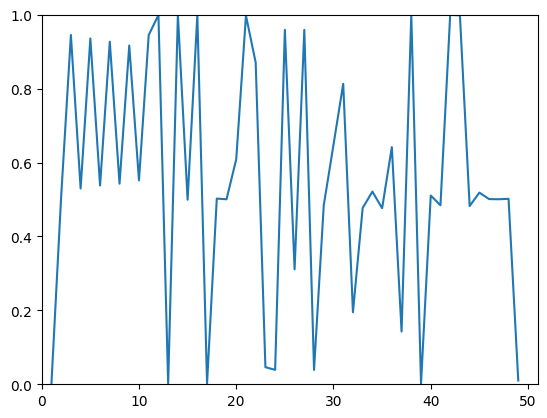

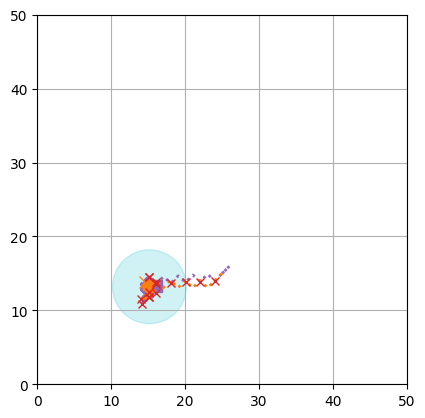

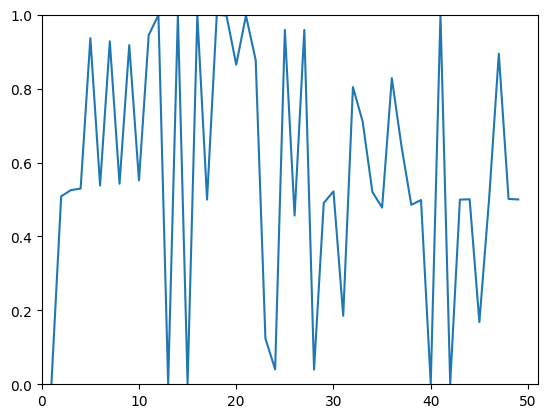

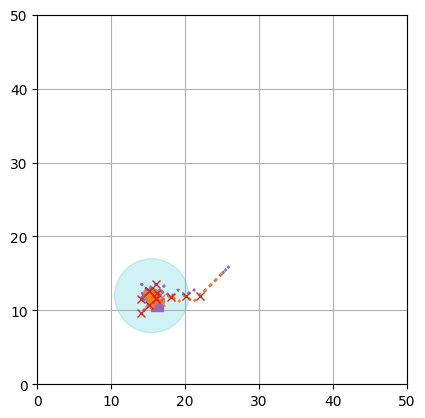

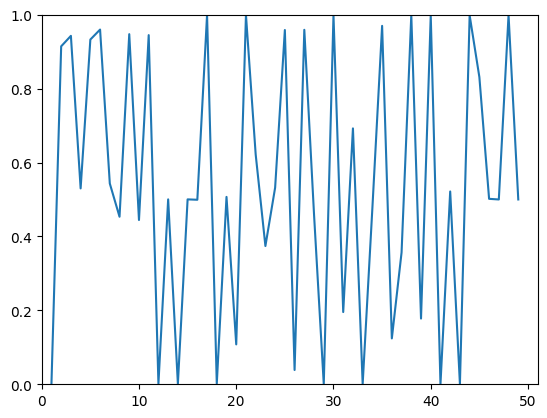

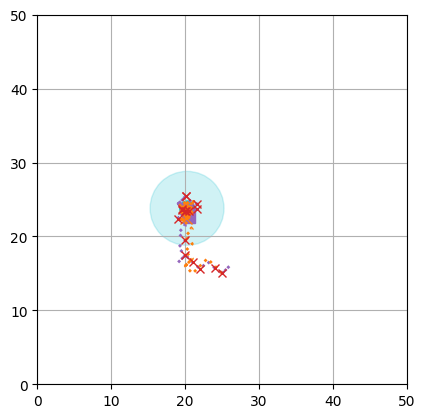

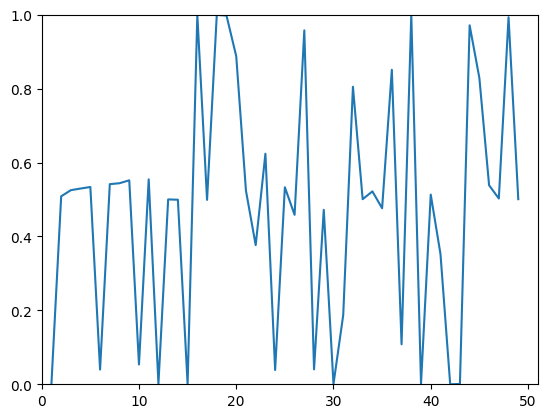

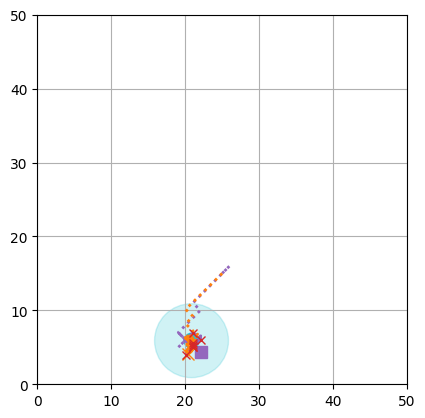

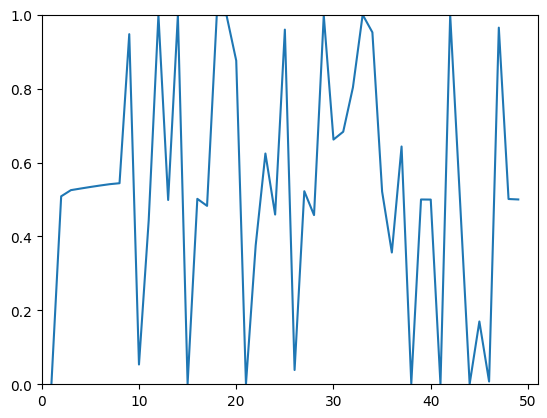

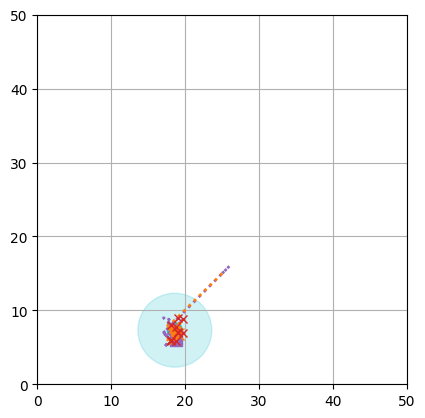

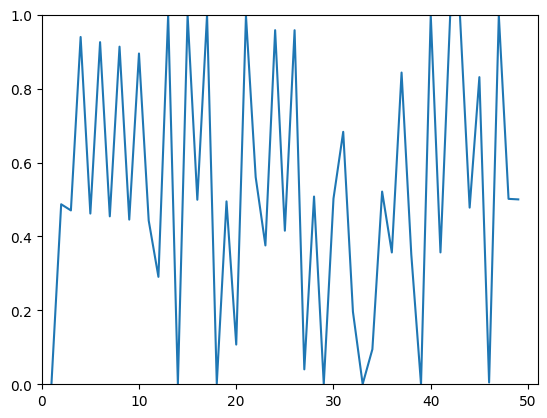

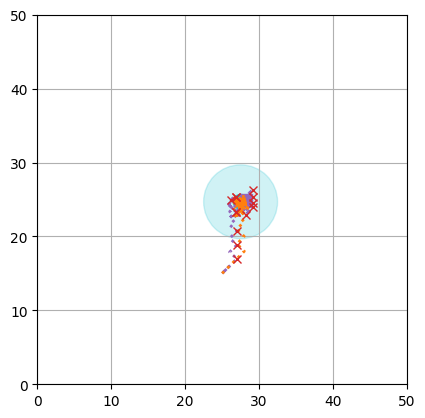

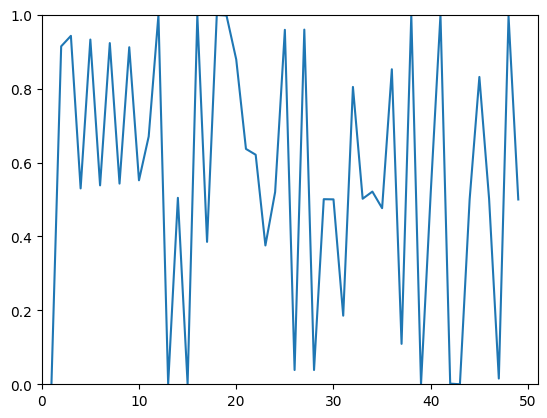

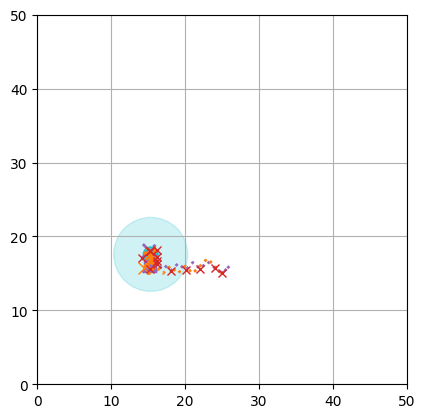

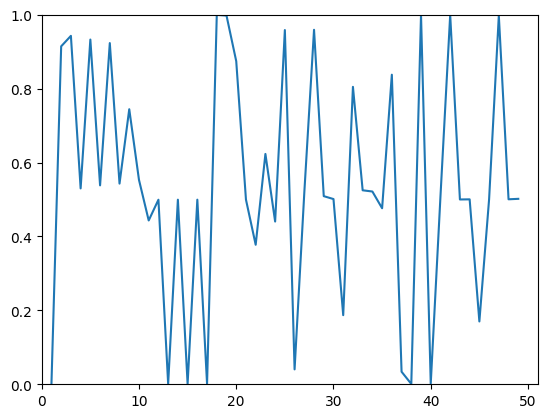

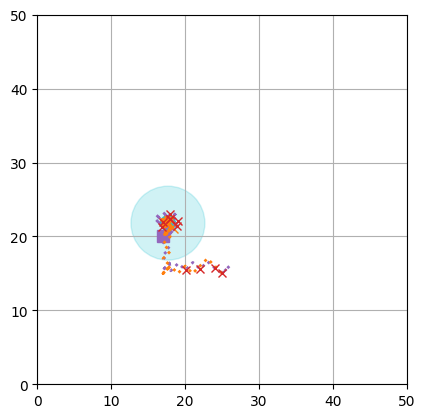

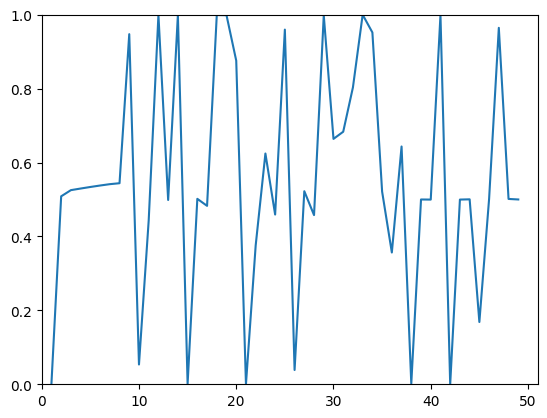

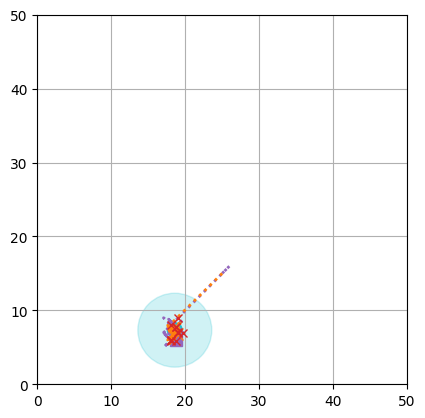

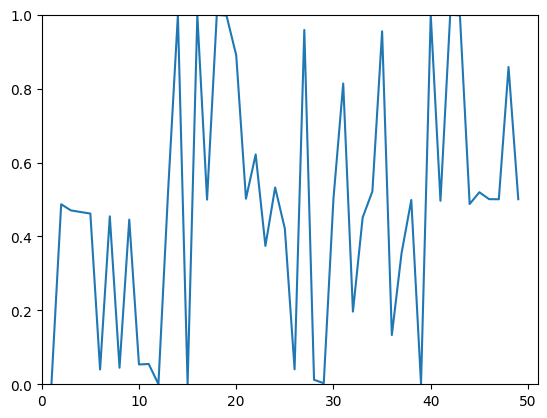

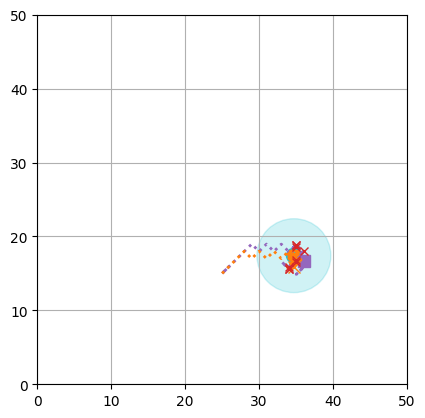

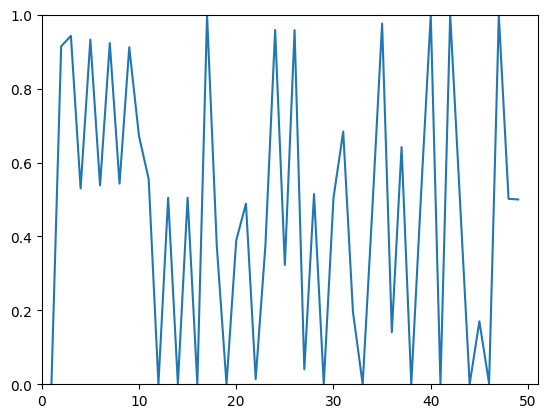

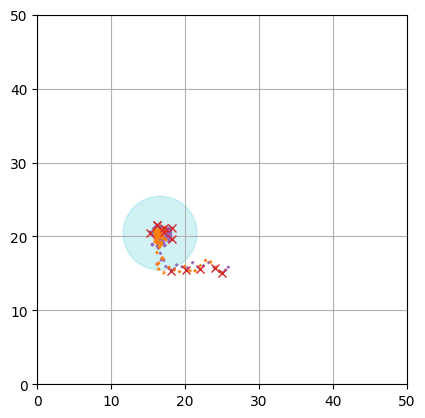

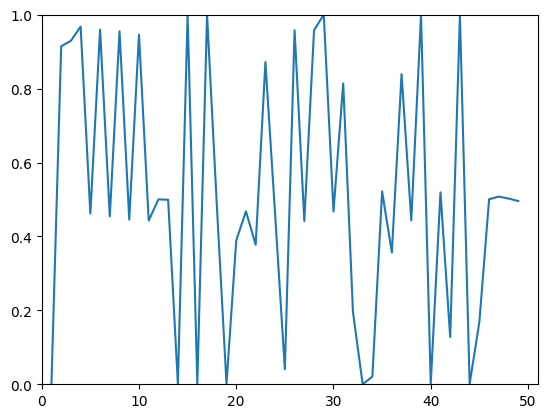

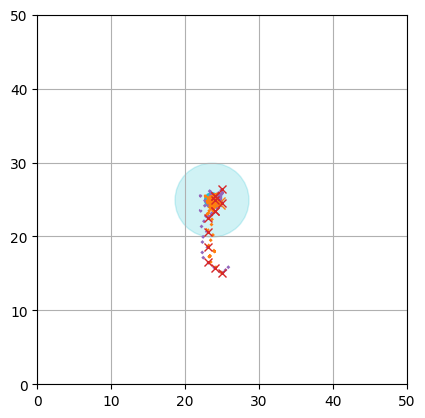

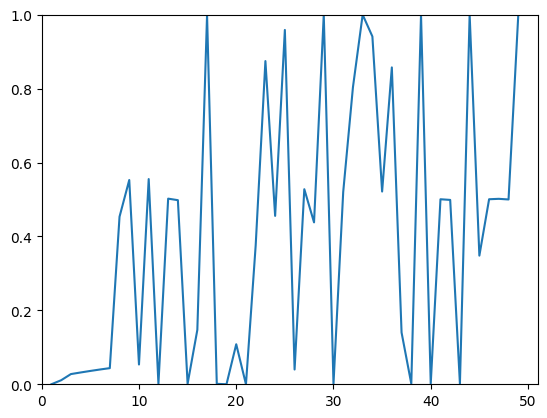

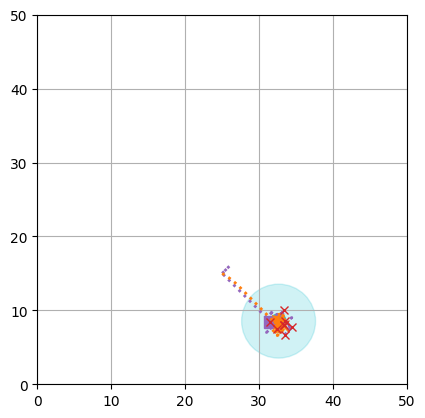

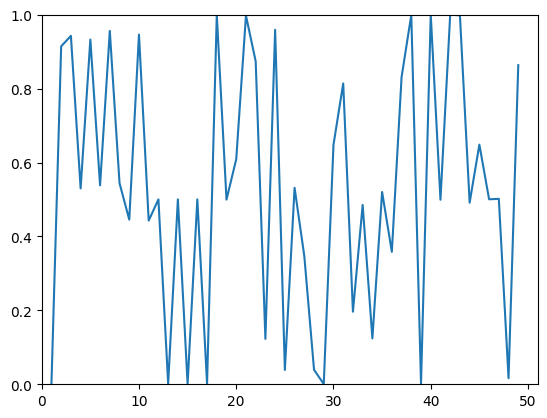

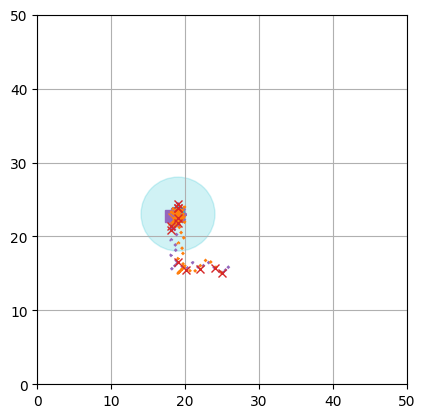

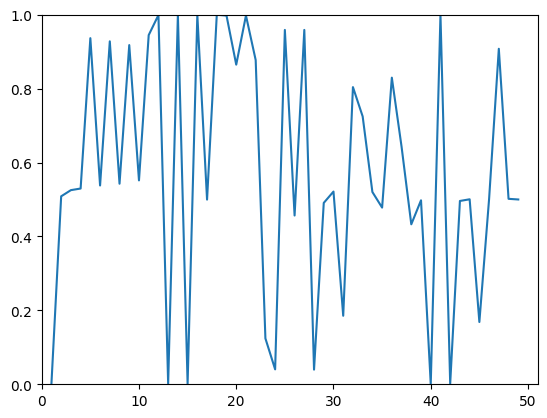

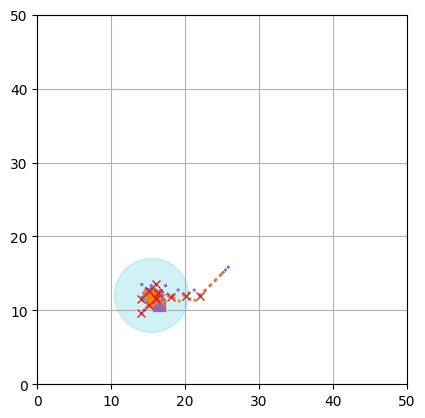

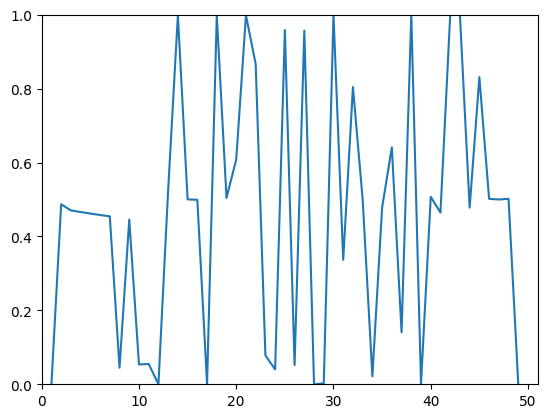

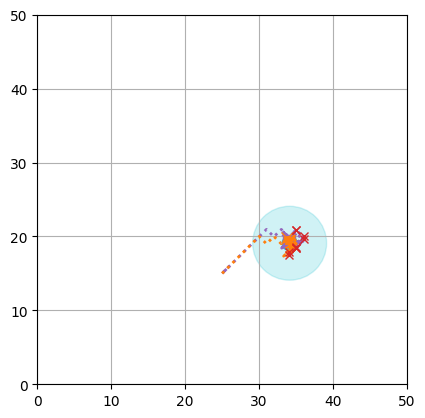

In [68]:
# Going back through the joint trajectory to see if there are points that actually
# stand out as moments of high influence
# Maybe when the uav moves to a different quadrant of the rover, that has a big impact on what the rover does

# Let's do this for every joint trajectory
%matplotlib inline

threshold = 0.9 # Action distance threshold

x_root_original_trajs = Path(os.path.expanduser('~/influence-shaping/results/02_19_2025/01_influence/'))
out_x_root_original_trajs = Path(os.path.expanduser('~/influence-shaping/outfigs/02_19_2025/01_influence/'))
root_original_trajs = x_root_original_trajs / 'original' / 'traj' / 'traj'

if not os.path.exists(root_original_trajs):
    os.makedirs(root_original_trajs)

traj_csvs = sorted(os.listdir(root_original_trajs), key=lambda x : int(x.split('.')[0].split('_')[-1]) )

if not os.path.exists(out_x_root_original_trajs / 'influence_pts' / 'traj' / 'traj'):
    os.makedirs(out_x_root_original_trajs / 'influence_pts' / 'traj' / 'traj')

if not os.path.exists(out_x_root_original_trajs / 'reaction_distance'):
    os.makedirs(out_x_root_original_trajs / 'reaction_distance')

# Get the individual agent and poi configs within the config
rover_config = config['env']['agents']['rovers'][0]
uav_config = config['env']['agents']['uavs'][0]
poi_config = config['env']['pois']['hidden_pois'][0]

# Set up the rover's neural network policy
rover_nn = NeuralNetwork(
    num_inputs=12,
    num_hidden=[15],
    num_outputs=2,
    hidden_activation_func='tanh',
    output_activation_func='tanh'
)
rover_nn.setWeights(elite_team[0])

for traj_csv in traj_csvs:
    # -- Compute the action distance

    # First let's do resim for this traj
    traj_df = pd.read_csv(root_original_trajs / traj_csv)
    eval_infos = []
    for t, row in enumerate(traj_df.itertuples(index=False)):
        # Simulate a counterfactual action from the uav
        resim_eval_info = resim_env(
            num_steps=2,
            rover_config=rover_config,
            uav_config=uav_config,
            poi_config=poi_config,
            poi_position=[
                float(row.hidden_poi_0_x),
                float(row.hidden_poi_0_y)
            ],
            uav_position=[
                float(row.uav_0_x),
                float(row.uav_0_y)
            ],
            rover_position=[
                float(row.rover_0_x),
                float(row.rover_0_y)
            ],
            uav_action=[0., 0.],
            rover_action=None,
            uav_policy_function=None,
            rover_policy_function=rover_nn
        )
        eval_infos.append(resim_eval_info)

    # Now we need to extract the rover actions and counterfactual actions
    rover_actions = np.array([np.array([row.rover_0_dx, row.rover_0_dy]) for row in traj_df.itertuples(index=False)][1:])

    # Then let's collect counterfactual rover actions
    cfac_actions = np.array([np.array([df['rover_0_dx'][1], df['rover_0_dy'][1]]) for df in short_traj_dfs][:-1])

    # Running a normalization on the difference between rover reaction to uav and counterfactual reaction
    steps = np.arange(49)+1
    rover_dist = np.mean(np.abs( (cfac_actions-rover_actions)/2 ) , axis=1)

    traj_png = traj_csv.split('.')[0]+'.png'

    # Plot the reaction distance
    fig, ax = plt.subplots(1,1)

    ax.plot(steps, rover_dist)

    ax.set_ylim([0,1])
    ax.set_xlim([0,len(steps)+2])

    fig.savefig(out_x_root_original_trajs / 'reaction_distance' / traj_png)

    # Now plot joint traj and points of influence
    fig = generate_joint_trajectory_plot(
        joint_traj_dir= root_original_trajs / traj_csv,
        individual_colors=False,
        no_shading=False,
        plot_args=PlotArgs()
    );

    ax = fig.axes[0]

    for step, dist in zip(steps, rover_dist):
        if dist > threshold:
            ax.plot(traj_df['rover_0_x'][step], traj_df['rover_0_y'][step], marker='x', color='tab:red')

    fig.savefig(out_x_root_original_trajs / 'influence_pts' / 'traj' / 'traj' / traj_png)

In [49]:
plt.close()

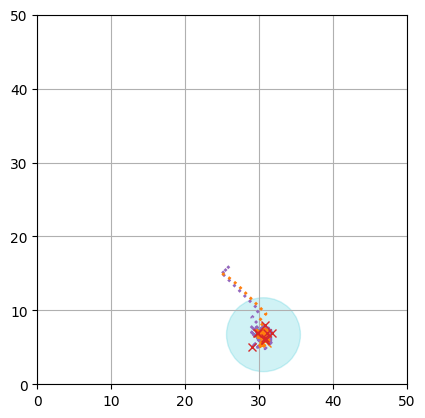

In [50]:


fig = generate_joint_trajectory_plot(
    joint_traj_dir=Path(os.path.expanduser('~/influence-shaping/results/02_19_2025/01_influence/original/traj/traj/traj_0.csv')),
    individual_colors=False,
    no_shading=False,
    plot_args=PlotArgs()
);

ax = fig.axes[0]

threshold = 0.9
for step, dist in zip(steps, rover_dist):
    if dist > threshold:
        ax.plot(traj_dfs[0]['rover_0_x'][step], traj_dfs[0]['rover_0_y'][step], marker='x', color='tab:red')

In [ ]:
traj_dfs[0]
"""
Even though we are measuring the action distance, its the state that gives us the reward, not the action
Spikes means we transition from rewarding to non-rewarding state
The influence earlier will not give you a reward
View it at a trajectory level vs at each time step because that is likely to be more stable

"""

rover_0_x  rover_0_y    uav_0_x    uav_0_y  hidden_poi_0_x  \
0   25.000000  15.000000  25.000000  15.000000       30.590752   
1   26.000000  16.000000  26.000000  14.350511       30.590752   
2   25.003027  15.000000  26.999999  13.531967       30.590752   
3   26.002027  14.001886  27.982835  12.531967       30.590752   
4   27.001025  13.003779  28.967756  11.531968       30.590752   
5   28.000020  12.005676  29.954483  10.531968       30.590752   
6   28.999013  11.007578  30.942728   9.531969       30.590752   
7   29.998005  10.009484  29.942728   8.531981       30.590752   
8   29.000603   9.009484  30.942728   7.574738       30.590752   
9   29.999589   8.011403  29.942728   6.574750       30.590752   
10  29.002114   7.011403  30.942724   7.574750       30.590752   
11  30.002114   8.004343  29.942731   7.308953       30.590752   
12  29.002199   7.004343  30.942730   6.351553       30.590752   
13  30.001113   6.006600  29.942757   5.354437       30.590752   
14  29.001164   5.006600  30.942753   6.354437       30.590752   
15  30.001164   5.999544  29.942753   7.353301       30.590752   
16  29.002342   6.983671  30.320225   6.353301       30.590752   
17  30.001833   5.990271  31.320224   7.350553       30.590752   
18  31.001833   6.983215  30.320231   7.086389       30.590752   
19  31.365239   7.983215  30.640724   6.086389       30.590752   
20  30.370023   6.983215  29.640987   7.086351       30.590752   
21  30.762207   7.983214  29.915010   6.086351       30.590752   
22  29.767279   6.983214  30.915006   7.086351       30.590752   
23  30.767279   7.978885  29.915013   6.821661       30.590752   
24  29.769803   6.978885  30.915012   5.855301       30.590752   
25  30.768976   5.982980  29.915041   4.857928       30.590752   
26  29.771461   4.982980  30.915038   5.857928       30.590752   
27  30.771461   5.976340  29.915038   6.856708       30.590752   
28  29.772876   6.970394  30.294376   5.856708       30.590752   
29  30.772814   6.000812  31.294375   6.853994       30.590752   
30  31.772814   6.999333  30.294382   6.593783       30.590752   
31  30.775526   5.999333  31.294379   7.593783       30.590752   
32  31.775526   6.992339  30.294385   7.333818       30.590752   
33  30.776814   7.959090  30.715372   6.333818       30.590752   
34  29.779771   6.959090  29.715627   7.333782       30.590752   
35  28.780051   7.959090  29.928318   6.333782       30.590752   
36  29.778962   6.961441  30.928318   7.330997       30.590752   
37  30.778961   7.956342  29.928325   7.068878       30.590752   
38  29.781223   6.956342  30.928324   6.104913       30.590752   
39  30.780796   5.963987  29.928353   5.107600       30.590752   
40  29.783034   4.963987  30.928349   6.107600       30.590752   
41  30.783034   5.957036  29.928349   7.106426       30.590752   
42  29.784224   6.933518  30.329749   6.106426       30.590752   
43  30.784223   6.248288  31.329748   7.103725       30.590752   
44  31.784222   7.246548  30.329755   6.845123       30.590752   
45  30.786882   6.246548  31.329755   5.875689       30.590752   
46  31.786882   5.794930  30.329787   4.878076       30.590752   
47  30.790156   4.794930  31.329784   5.878076       30.590752   
48  31.790155   5.789797  30.329784   6.876812       30.590752   
49  30.792377   6.714409  30.823658   5.876812       30.590752   

    hidden_poi_0_y  rover_0_dx  rover_0_dy  uav_0_dx  uav_0_dy  ...  \
0         6.708831    1.000000    1.000000  1.000000 -0.649489  ...   
1         6.708831   -0.996973   -1.000000  1.000000 -0.818544  ...   
2         6.708831    0.999000   -0.998114  0.982836 -1.000000  ...   
3         6.708831    0.998998   -0.998108  0.984920 -1.000000  ...   
4         6.708831    0.998995   -0.998103  0.986727 -1.000000  ...   
5         6.708831    0.998993   -0.998098  0.988246 -1.000000  ...   
6         6.708831    0.998992   -0.998094 -1.000000 -0.999988  ...   
7         6.708831   -0.997402   -1.000000  1.000000 -0.957243  ...  

In [52]:
# What if I think of this as a convolution where the input is the uav's action distance and the output is the rover's action distance

# Perform deconvolution
h, remainder = np.polydiv(rover_dist, uav_dist)

print("Estimated Impulse Response h:", h, " | Remainder:", remainder)

# Perform re convolution
y = np.convolve(uav_dist, h, mode='full')

print("Re constructed rover dist:", y)

Estimated Impulse Response h: [0.0005922]  | Remainder: [ 4.86516852e-01  4.69824831e-01  4.65498396e-01  4.61327165e-01
  4.57404623e-01  4.53765478e-01  4.40933359e-02  4.44976451e-01
  5.29842934e-02  5.45370707e-02 -2.57122692e-04  5.24948242e-01
  9.97973571e-01  4.99522016e-01  4.98854084e-01 -5.81758008e-04
  9.98817269e-01  5.03912129e-01  6.07588113e-01  9.97959833e-01
  8.65934613e-01  7.75177656e-02  3.98169897e-02  9.57936283e-01
  5.15480454e-02  9.56324805e-01 -3.93767876e-04  1.87559543e-03
  9.99626759e-01  3.36169577e-01  8.03785591e-01  4.99608866e-01
  2.10722807e-02  4.77633747e-01  6.40384835e-01  1.40216055e-01
  9.98706686e-01  7.79391663e-04  5.06568169e-01  4.63985598e-01
  9.98297172e-01  9.99363680e-01  4.77572691e-01  8.30403748e-01
  5.01160971e-01  4.99420099e-01  5.01159965e-01 -4.41092432e-04]
Re constructed rover dist: [0.00048841 0.00053847 0.00058711 0.00058773 0.00058827 0.00058872
 0.00059219 0.00057954 0.00059219 0.0005922  0.0003748  0.00057958
 0

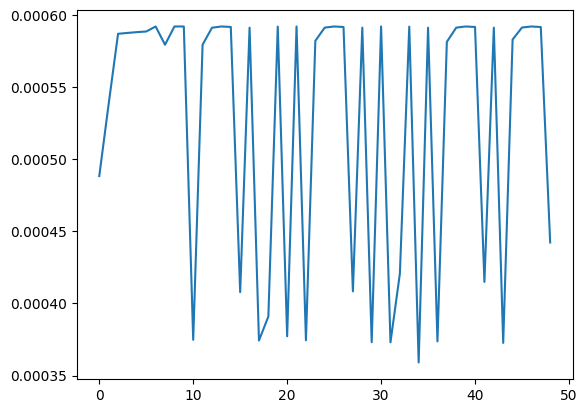

In [53]:
fig, ax = plt.subplots(1,1)
ax.plot(y)

In [54]:
# Let's measure the difference between counterfactual actions and the original actions
# (Maybe better to think of them as counterfactual re-actions? The rover is "re-acting" to the counterfactual action of the uav)
distances = np.linalg.norm(cfac_actions-rover_actions, axis=1)
distances
# threshold = 1.0
# distances[distances>=threshold] = 1
# distances[distances<threshold] = 0
# distances

array([1.95363666e-03, 1.94818696e+00, 1.88164007e+00, 1.86433850e+00,
       1.84765687e+00, 1.83196931e+00, 1.81742723e+00, 1.77760473e-01,
       1.78227211e+00, 2.13373279e-01, 2.18563811e-01, 1.28962645e-03,
       1.99952030e+00, 2.82437112e+00, 1.99886953e+00, 1.99595860e+00,
       3.81468481e-05, 2.82614151e+00, 1.99754606e+00, 2.04382305e+00,
       2.82372387e+00, 2.47950455e+00, 3.11566199e-01, 1.61245686e-01,
       2.71338358e+00, 2.04326494e-01, 2.70864662e+00, 5.84906877e-05,
       9.86795403e-03, 2.82842685e+00, 1.25921903e+00, 2.34098241e+00,
       2.00000000e+00, 8.55873262e-02, 1.91196007e+00, 2.07598889e+00,
       5.62103051e-01, 2.82641461e+00, 5.48285366e-03, 1.99897718e+00,
       1.85830502e+00, 2.82478681e+00, 2.82830007e+00, 1.90908183e+00,
       2.39850710e+00, 1.99996336e+00, 2.00000000e+00, 1.99996309e+00,
       4.96546125e-06])

In [55]:
distances[-1]

np.float64(4.965461245678061e-06)

In [56]:
rover_actions[-1]

array([-0.99995034,  1.        ])

In [57]:
cfac_actions[-1]

array([-0.99994538,  1.        ])

In [58]:
np.sqrt(8)

np.float64(2.8284271247461903)

In [59]:
np

<module 'numpy' from '/home/gonzaeve/miniconda3/envs/influence/lib/python3.10/site-packages/numpy/__init__.py'>